# Extract the CMIP6 and CMIP5 climate
- and save the global climate in 2100 (using the definition as in the IPCC AR6 WG1 report)
- attention: that means we assume here in this notebook a warming of 0.69°C between 1850-1900 and 1986-2005 (as done in the IPCC AR6 report)
    - in Rounce et al., they used 0.63°C of warming as they used the estimates from the older SROCC IPCC report
- notebook is the same as in : https://cluster.klima.uni-bremen.de/~oggm/oggm-standard-projections/analysis_notebooks/global_gcm_climate_cmip6_cmip5_ipcc_ar6_def.ipynb

In [1]:
from oggm import utils
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import seaborn as sns


In [2]:
gcms_cmip6_2300 = pd.read_csv('/home/www/oggm/cmip6/all_gcm_list_2300.csv', index_col=0)  
gcms_cmip6 = pd.read_csv('/home/www/oggm/cmip6/all_gcm_list.csv', index_col=0)   

gcms_ssps = []
for ind in gcms_cmip6.loc[gcms_cmip6['var']=='pr'].index:
    gcms_ssps.append(f'{gcms_cmip6.loc[ind].gcm}_{gcms_cmip6.loc[ind].ssp}')
gcm_c = {}
for e,gcm in enumerate(['CanESM5', 'IPSL-CM6A-LR', 'CESM2-WACCM', 'MRI-ESM2-0',
       'ACCESS-CM2', 'ACCESS-ESM1-5']):
    gcm_c[gcm] = f'C{e}'

In [3]:
print(len(gcms_cmip6)/2)

73.0


In [4]:
past_warming = 0.69 # for IPCC AR6 WG1 report 

In [5]:
extract_cmip6_climate = True
if extract_cmip6_climate:
    pd_temp_ch_2100_2300 = pd.DataFrame(columns=['gcm', 'ssp','global_temp_ch_2081-2100_preindustrial',
                                                                  'global_temp_ch_2071-2100_preindustrial',
                                                                  'global_temp_ch_2281-2300_preindustrial'])
    for ssp in gcms_cmip6.ssp.unique():
        gcms_cmip6_sel = gcms_cmip6.loc[(gcms_cmip6.ssp ==ssp) & (gcms_cmip6['var'] =='tas')]
        for f in gcms_cmip6_sel.index:
            gcm = gcms_cmip6_sel.loc[f].gcm
            dtas_annual = xr.open_dataset(gcms_cmip6_sel.loc[f]['path'],
                                          use_cftime=True).sel(time=slice('1986','2300')).tas.groupby('time.year').mean()
            weight = np.cos(np.deg2rad(dtas_annual.lat))
            weight = weight/weight.sum()
            global_dtas_per_year = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')
            avg_1986_2005 = global_dtas_per_year.sel(year=slice('1986','2005')).mean().values
            avg_2081_2100 = global_dtas_per_year.sel(year=slice('2081','2100')).mean().values
            avg_2071_2100 = global_dtas_per_year.sel(year=slice('2071','2100')).mean().values
            avg_2271_2300 = global_dtas_per_year.sel(year=slice('2271','2300')).mean().values
            avg_2281_2300 = global_dtas_per_year.sel(year=slice('2281','2300')).mean().values

            temperature_increase_2081_2100_rel_preindustrial = avg_2081_2100- avg_1986_2005 + past_warming
            temperature_increase_2071_2100_rel_preindustrial = avg_2071_2100- avg_1986_2005 + past_warming
            temperature_increase_2271_2300_rel_preindustrial = avg_2271_2300- avg_1986_2005 + past_warming
            temperature_increase_2281_2300_rel_preindustrial = avg_2281_2300- avg_1986_2005 + past_warming

            pd_temp_ch_2100_2300.loc[f'{gcm.upper()}_{ssp}', 'global_temp_ch_2081-2100_preindustrial'] =  temperature_increase_2081_2100_rel_preindustrial
            pd_temp_ch_2100_2300.loc[f'{gcm.upper()}_{ssp}', 'global_temp_ch_2071-2100_preindustrial'] =  temperature_increase_2071_2100_rel_preindustrial
            pd_temp_ch_2100_2300.loc[f'{gcm.upper()}_{ssp}', 'global_temp_ch_2281-2300_preindustrial'] =  temperature_increase_2281_2300_rel_preindustrial
            pd_temp_ch_2100_2300.loc[f'{gcm.upper()}_{ssp}', 'global_temp_ch_2271-2300_preindustrial'] =  temperature_increase_2271_2300_rel_preindustrial

            pd_temp_ch_2100_2300.loc[f'{gcm.upper()}_{ssp}', 'gcm'] = gcm.upper()
            pd_temp_ch_2100_2300.loc[f'{gcm.upper()}_{ssp}', 'ssp'] = ssp
            
    for j in pd_temp_ch_2100_2300.index:
        temp_ch_2081_2100_rel_preind = pd_temp_ch_2100_2300.loc[j, 'global_temp_ch_2081-2100_preindustrial'] 
        if (temp_ch_2081_2100_rel_preind <=1.75) and ((temp_ch_2081_2100_rel_preind >=1.25)):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2081-2100_preindustrial_+1.5°C'] = True
        if (temp_ch_2081_2100_rel_preind <=2.5) and ((temp_ch_2081_2100_rel_preind >=1.5)):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2081-2100_preindustrial_+2.0°C'] = True
        if (temp_ch_2081_2100_rel_preind <=3.5) and ((temp_ch_2081_2100_rel_preind >=2.5)):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2081-2100_preindustrial_+3.0°C'] = True
        if (temp_ch_2081_2100_rel_preind <=4.5) and ((temp_ch_2081_2100_rel_preind >=3.5)):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2081-2100_preindustrial_+4.0°C'] = True
        if (temp_ch_2081_2100_rel_preind <=5.5) and ((temp_ch_2081_2100_rel_preind >=4.5)):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2081-2100_preindustrial_+5.0°C'] = True
        if (temp_ch_2081_2100_rel_preind <=6.5) and ((temp_ch_2081_2100_rel_preind >=5.5)):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2081-2100_preindustrial_+6.0°C'] = True
    
    for j in pd_temp_ch_2100_2300.index:
        temp_ch_2071_2100_rel_preind = pd_temp_ch_2100_2300.loc[j, 'global_temp_ch_2071-2100_preindustrial'] 
        if (temp_ch_2071_2100_rel_preind <=1.5):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2071-2100_preindustrial_<=+1.5°C'] = True
        elif (temp_ch_2071_2100_rel_preind<=2.0):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2071-2100_preindustrial_<=+2.0°C'] = True
        elif (temp_ch_2071_2100_rel_preind<=3.0):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2071-2100_preindustrial_<=+3.0°C'] = True
        elif (temp_ch_2071_2100_rel_preind<=4.0):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2071-2100_preindustrial_<=+4.0°C'] = True
        elif (temp_ch_2071_2100_rel_preind>4.0):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2071-2100_preindustrial_>4.0°C'] = True
    pd_temp_ch_2100_2300.to_csv('Global_mean_temp_deviation_2071_2100_2081_2100_2271_2300_2281_2300_rel_1850_1900_cmip6_gcms_ipcc_ar6_def.csv')


In [7]:
pd_temp_ch_2100_2300 = pd.read_csv('Global_mean_temp_deviation_2071_2100_2081_2100_2271_2300_2281_2300_rel_1850_1900_cmip6_gcms_ipcc_ar6_def.csv', index_col=0)

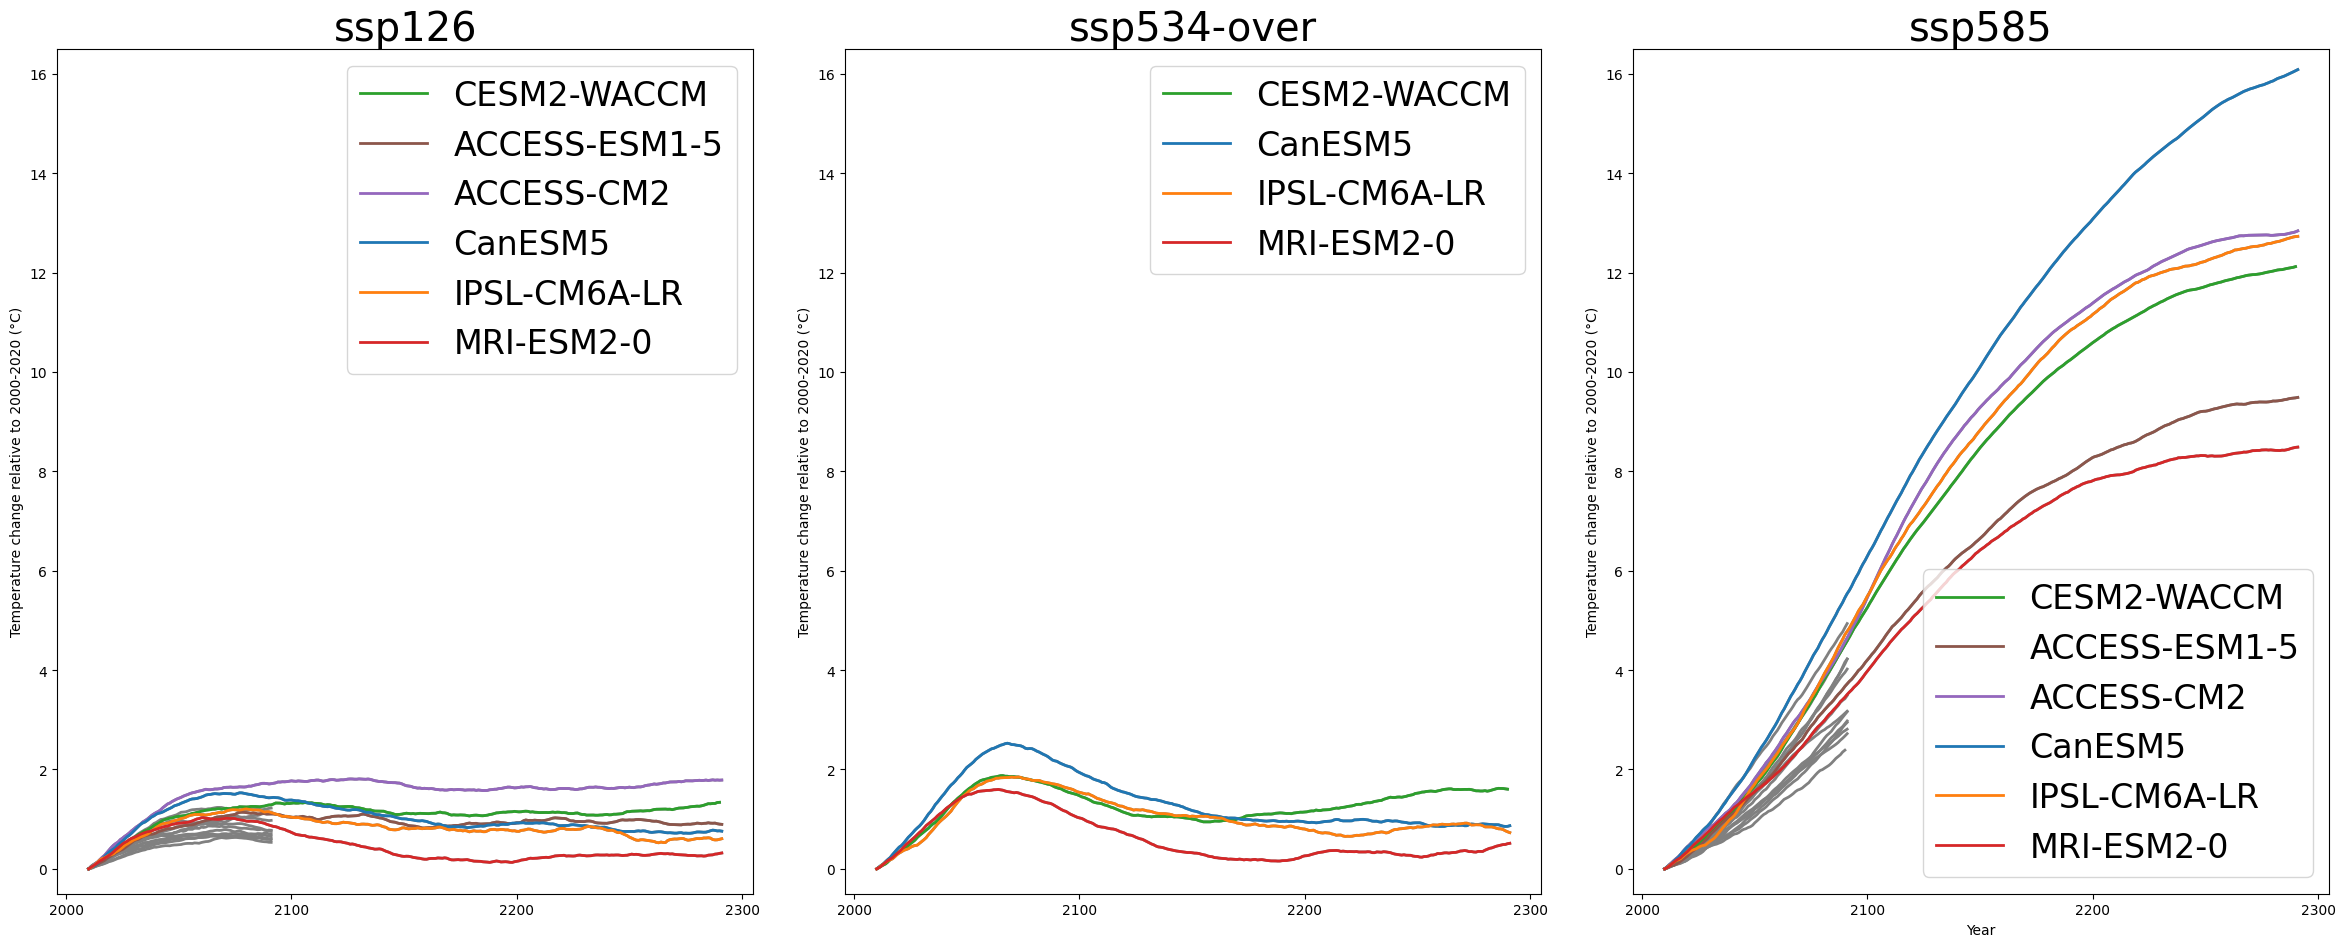

In [8]:
fig,axs = plt.subplots(1,3,figsize=(24,10))
plt.rc('font', size=24)
for ax,ssp in  zip(axs,['ssp126','ssp534-over','ssp585']):
    gcms_cmip6_2300_over = gcms_cmip6.loc[(gcms_cmip6.ssp ==ssp) & (gcms_cmip6['var'] =='tas')]
    for f in gcms_cmip6_2300_over.index:
        dtas_annual = xr.open_dataset(gcms_cmip6_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('2000','2300')).tas.groupby('time.year').mean()

        weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()
        global_dtas_per_year = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')
        avg_1986_2005 = global_dtas_per_year.sel(year=slice('1986','2005')).mean().values
        avg_2071_2100 = global_dtas_per_year.sel(year=slice('2071','2100')).mean().values
        temperature_increase_2071_2100_rel_preindustrial = avg_2071_2100- avg_1986_2005 + past_warming

        # get the global means for every month:
        global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=20, center=True).mean()
        ax.plot(global_dtas.year, global_dtas-global_dtas.sel(year=2010), lw=2,
                color= 'grey')
ax.set_xlabel('Year')
     
for ax,ssp in  zip(axs,['ssp126','ssp534-over','ssp585']):
    gcms_cmip6_2300_over = gcms_cmip6_2300.loc[(gcms_cmip6_2300.ssp ==ssp) & (gcms_cmip6_2300['var'] =='tas')]
    for f in gcms_cmip6_2300_over.index:
        dtas_annual = xr.open_dataset(gcms_cmip6_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('2000','2300')).tas.groupby('time.year').mean()

        weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()

        # get the global means for every month:
        global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=20,
                                                                                    center=True).mean()
        ax.plot(global_dtas.year, global_dtas-global_dtas.sel(year=2010), lw=2,
                label=gcms_cmip6_2300_over.loc[f].gcm, 
                color= gcm_c[gcms_cmip6_2300_over.loc[f].gcm])
    ax.set_ylim([-0.5,16.5])
    ax.set_ylabel('Temperature change rel. to 2000-2020 (°C)')
    ax.legend()
    ax.set_title(ssp)
    
ax.set_xlabel('Year')

plt.tight_layout()
#plt.savefig('gcm_global_temp_change_cmip6_ipcc_ar6_def.png')

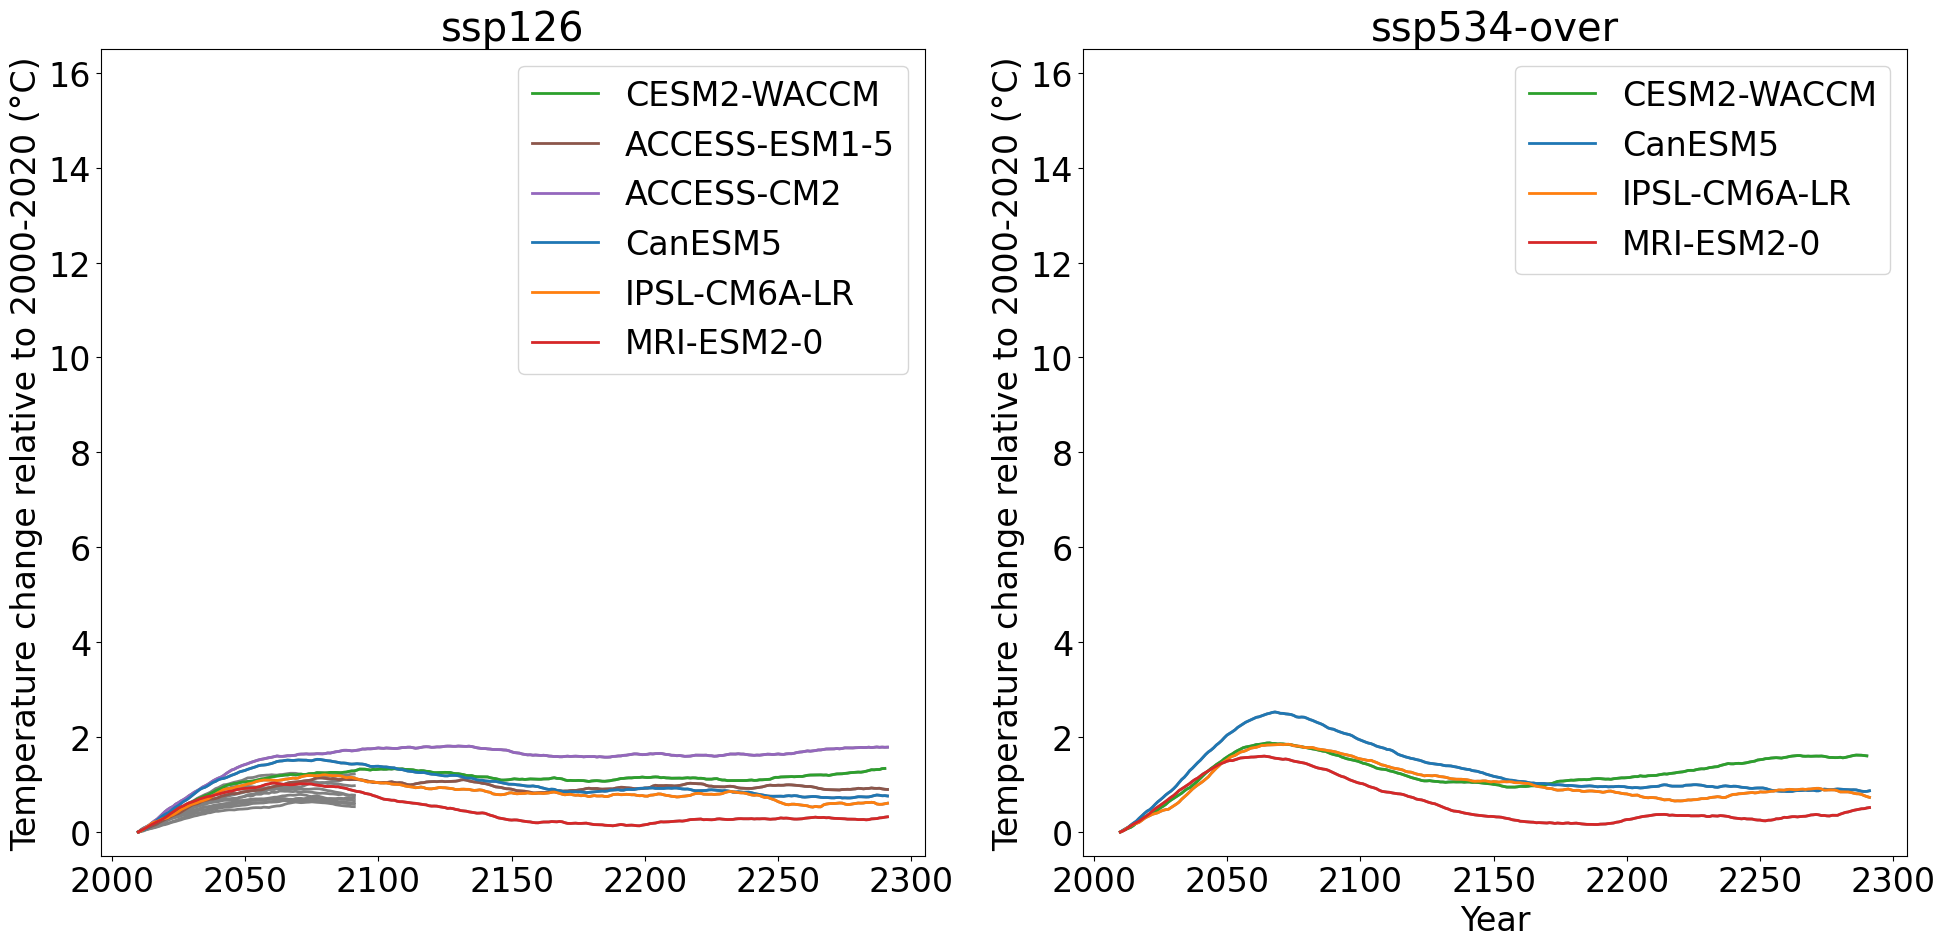

In [9]:
fig,axs = plt.subplots(1,2,figsize=(20,10))

plt.rc('font', size=24)
for ax,ssp in  zip(axs,['ssp126','ssp534-over']): #,'ssp585']):
    gcms_cmip6_2300_over = gcms_cmip6.loc[(gcms_cmip6.ssp ==ssp) & (gcms_cmip6['var'] =='tas')]
    for f in gcms_cmip6_2300_over.index.sort_values():
        dtas_annual = xr.open_dataset(gcms_cmip6_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('2000','2300')).tas.groupby('time.year').mean()

        weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()

        # get the global means for every month:
        global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=20, center=True).mean()
        ax.plot(global_dtas.year, global_dtas-global_dtas.sel(year=2010), lw=2,
                color= 'grey')
ax.set_xlabel('Year')

for ax,ssp in  zip(axs,['ssp126','ssp534-over']): #,'ssp585']):
    gcms_cmip6_2300_over = gcms_cmip6_2300.loc[(gcms_cmip6_2300.ssp ==ssp) & (gcms_cmip6_2300['var'] =='tas')]
    for f in gcms_cmip6_2300_over.index.sort_values():
        dtas_annual = xr.open_dataset(gcms_cmip6_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('2000','2300')).tas.groupby('time.year').mean()

        weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()

        # get the global means for every month:
        global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=20, center=True).mean()
        ax.plot(global_dtas.year, global_dtas-global_dtas.sel(year=2010), lw=2,
                label=gcms_cmip6_2300_over.loc[f].gcm, 
                color= gcm_c[gcms_cmip6_2300_over.loc[f].gcm])
    ax.set_ylim([-0.5,16.5])
    ax.set_ylabel('Temperature change relative to 2000-2020 (°C)')
    ax.legend()
    ax.set_title(ssp)
    
ax.set_xlabel('Year')
plt.tight_layout()
#plt.savefig('gcm_global_temp_change_cmip6_no_ssp585_ipcc_ar6_def.png')

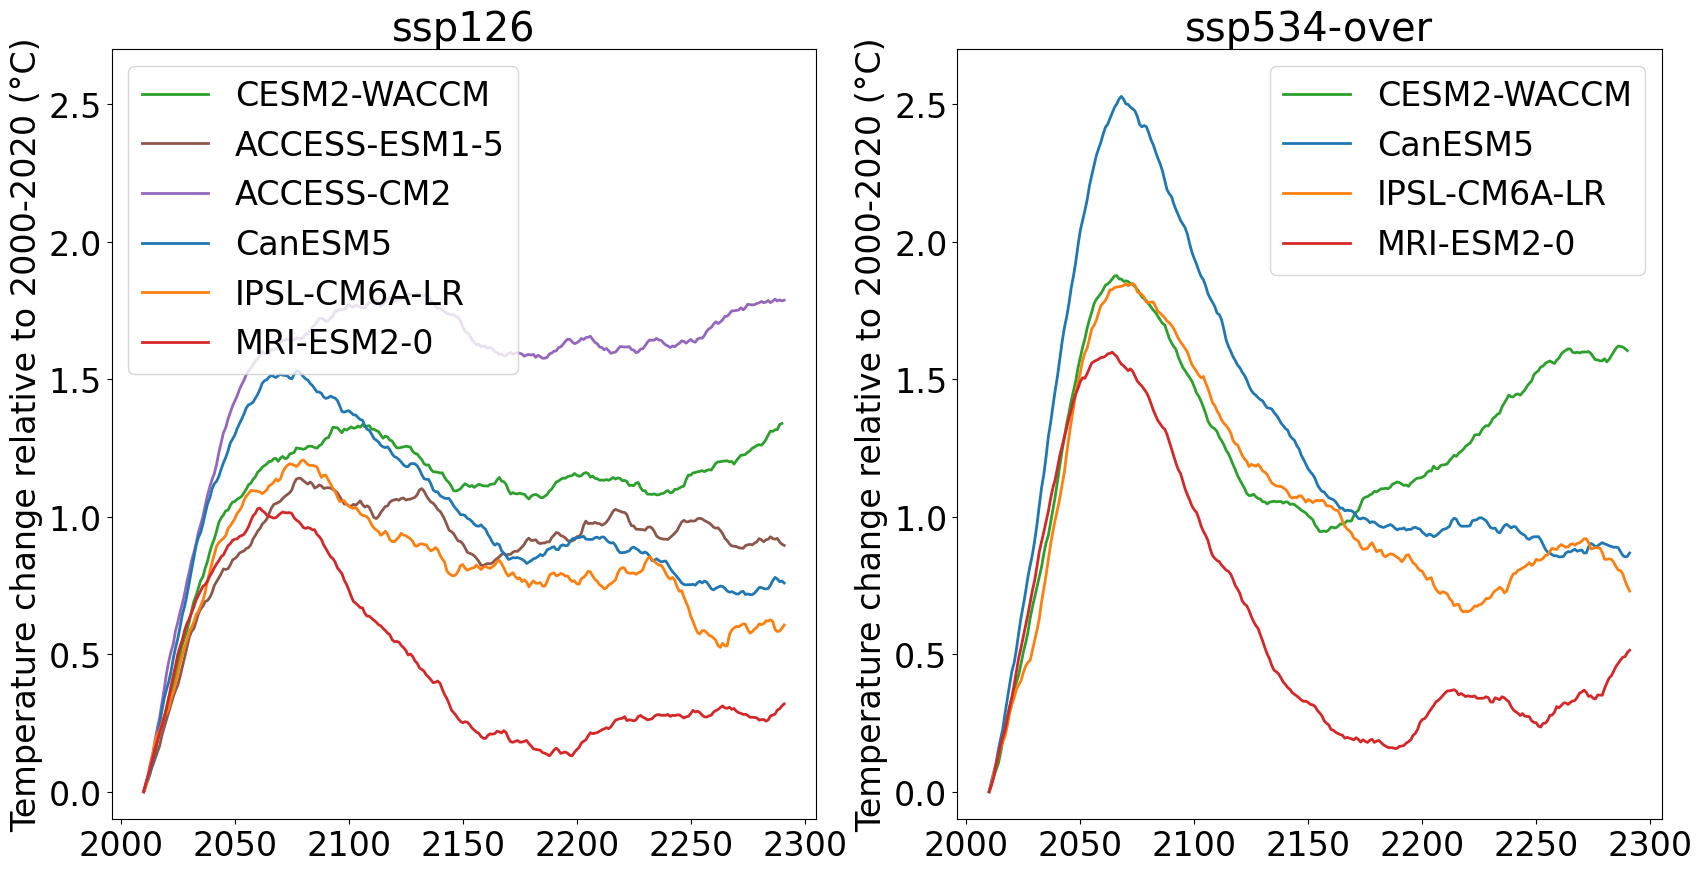

In [10]:
fig,axs = plt.subplots(1,2,figsize=(20,10))
plt.rc('font', size=24)

for ax,ssp in  zip(axs,['ssp126','ssp534-over']):
    gcms_cmip6_2300_over = gcms_cmip6_2300.loc[(gcms_cmip6_2300.ssp ==ssp) & (gcms_cmip6_2300['var'] =='tas')]
    for f in gcms_cmip6_2300_over.index:
        dtas_annual = xr.open_dataset(gcms_cmip6_2300_over.loc[f]['path'], use_cftime=True).sel(time=slice('2000','2300')).tas.groupby('time.year').mean()

        weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()

        # get the global means for every month:
        global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=20, center=True).mean()
        ax.plot(global_dtas.year, global_dtas-global_dtas.sel(year=2010), lw=2,
                label=gcms_cmip6_2300_over.loc[f].gcm,
               color= gcm_c[gcms_cmip6_2300_over.loc[f].gcm])
    ax.set_ylim([-0.1,2.7])

    ax.set_ylabel('Temperature change relative to 2000-2020 (°C)')
    ax.legend()
    ax.set_title(ssp)

- already globally, they are extremely different ... , regionally it will be even stronger discrepancies ... 

## CMIP5 

In [11]:
gcms_cmip5_2300 = pd.read_csv('/home/www/oggm/cmip5-ng/all_gcm_list_2300.csv', index_col=0).reset_index(drop=True) 
gcms_cmip5 = pd.read_csv('/home/www/oggm/cmip5-ng/all_gcm_list.csv', index_col=0).reset_index(drop=True)   
# we have used the regular interpolationgcms_cmip5.loc[gcms_cmip5.interpolation == '_g025']
gcms_rcps = []
for ind in gcms_cmip5.loc[gcms_cmip5['var']=='pr'].index:
    gcms_rcps.append(f'{gcms_cmip5.loc[ind].gcm}_{gcms_cmip5.loc[ind].rcp}')
gcm_c5 = {}
for e,gcm in enumerate(['CanESM2', 'MPI-ESM-LR', 'CESM1-CAM5', 'CSIRO-Mk3-6-0',
       'NorESM1-M', 'CCSM4']):
    gcm_c5[gcm] = f'C{e}'

In [12]:
extract_cmip5_climate = True
if extract_cmip5_climate:
    pd_temp_ch_2100_2300 = pd.DataFrame(#index=gcms_rcps,
                                        columns=['gcm', 'rcp','global_temp_ch_2081-2100_preindustrial',
                                                 'global_temp_ch_2071-2100_preindustrial',
                                                              'global_temp_ch_2281-2300_preindustrial'])

    for rcp in gcms_cmip5.rcp.unique():
        if 'rcp' in rcp:
            gcms_cmip5_sel = gcms_cmip5.loc[(gcms_cmip5.rcp==rcp) & (gcms_cmip5['var'] =='tas')]
            for f in gcms_cmip5_sel.index:
                gcm = gcms_cmip5_sel.loc[f].gcm
                #interpolation = gcms_cmip5_sel.loc[f].interpolation

                dtas_annual = xr.open_dataset(gcms_cmip5_sel.loc[f]['path'],
                                              use_cftime=True).sel(time=slice('1986','2300')).tas.groupby('time.year').mean()
                weight = np.cos(np.deg2rad(dtas_annual.lat))
                weight = weight/weight.sum()
                global_dtas_per_year = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')

                avg_1986_2005 = global_dtas_per_year.sel(year=slice('1986','2005')).mean().values
                avg_2081_2100 = global_dtas_per_year.sel(year=slice('2081','2100')).mean().values
                avg_2071_2100 = global_dtas_per_year.sel(year=slice('2071','2100')).mean().values
                avg_2271_2300 = global_dtas_per_year.sel(year=slice('2271','2300')).mean().values
                avg_2281_2300 = global_dtas_per_year.sel(year=slice('2281','2300')).mean().values

                temperature_increase_2081_2100_rel_preindustrial = avg_2081_2100- avg_1986_2005 + past_warming
                temperature_increase_2071_2100_rel_preindustrial = avg_2071_2100- avg_1986_2005 + past_warming
                temperature_increase_2271_2300_rel_preindustrial = avg_2271_2300- avg_1986_2005 + past_warming
                temperature_increase_2281_2300_rel_preindustrial = avg_2281_2300- avg_1986_2005 + past_warming

                pd_temp_ch_2100_2300.loc[f'{gcm.upper()}_{rcp}', 'global_temp_ch_2081-2100_preindustrial'] =  temperature_increase_2081_2100_rel_preindustrial
                pd_temp_ch_2100_2300.loc[f'{gcm.upper()}_{rcp}', 'global_temp_ch_2071-2100_preindustrial'] =  temperature_increase_2071_2100_rel_preindustrial
                pd_temp_ch_2100_2300.loc[f'{gcm.upper()}_{rcp}', 'global_temp_ch_2281-2300_preindustrial'] =  temperature_increase_2281_2300_rel_preindustrial
                pd_temp_ch_2100_2300.loc[f'{gcm.upper()}_{rcp}', 'global_temp_ch_2271-2300_preindustrial'] =  temperature_increase_2271_2300_rel_preindustrial             
                
                pd_temp_ch_2100_2300.loc[f'{gcm.upper()}_{rcp}', 'gcm'] = gcm.upper()
                pd_temp_ch_2100_2300.loc[f'{gcm.upper()}_{rcp}', 'rcp'] = rcp
                #pd_temp_ch_2100_2300.loc[f'{gcm}_{rcp}', 'interpolation'] = interpolation
            
    for j in pd_temp_ch_2100_2300.index:
        temp_ch_2081_2100_rel_preind = pd_temp_ch_2100_2300.loc[j, 'global_temp_ch_2081-2100_preindustrial'] 
        if (temp_ch_2081_2100_rel_preind <=1.75) and ((temp_ch_2081_2100_rel_preind >=1.25)):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2081-2100_preindustrial_+1.5°C'] = True
        if (temp_ch_2081_2100_rel_preind <=2.5) and ((temp_ch_2081_2100_rel_preind >=1.5)):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2081-2100_preindustrial_+2.0°C'] = True
        if (temp_ch_2081_2100_rel_preind <=3.5) and ((temp_ch_2081_2100_rel_preind >=2.5)):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2081-2100_preindustrial_+3.0°C'] = True
        if (temp_ch_2081_2100_rel_preind <=4.5) and ((temp_ch_2081_2100_rel_preind >=3.5)):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2081-2100_preindustrial_+4.0°C'] = True
        if (temp_ch_2081_2100_rel_preind <=5.5) and ((temp_ch_2081_2100_rel_preind >=4.5)):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2081-2100_preindustrial_+5.0°C'] = True
        if (temp_ch_2081_2100_rel_preind <=6.5) and ((temp_ch_2081_2100_rel_preind >=5.5)):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2081-2100_preindustrial_+6.0°C'] = True
            
    for j in pd_temp_ch_2100_2300.index:
        temp_ch_2071_2100_rel_preind = pd_temp_ch_2100_2300.loc[j, 'global_temp_ch_2071-2100_preindustrial'] 
        if (temp_ch_2071_2100_rel_preind <=1.5):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2071-2100_preindustrial_<=+1.5°C'] = True
        elif (temp_ch_2071_2100_rel_preind<=2.0):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2071-2100_preindustrial_<=+2.0°C'] = True
        elif (temp_ch_2071_2100_rel_preind<=3.0):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2071-2100_preindustrial_<=+3.0°C'] = True
        elif (temp_ch_2071_2100_rel_preind<=4.0):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2071-2100_preindustrial_<=+4.0°C'] = True
        elif (temp_ch_2071_2100_rel_preind>4.0):
            pd_temp_ch_2100_2300.loc[j,'global_temp_ch_level_2071-2100_preindustrial_>4.0°C'] = True
    pd_temp_ch_2100_2300.to_csv('Global_mean_temp_deviation_2071_2100_2081_2100_2271_2300_2281_2300_rel_1850_1900_cmip5_gcms_ipcc_ar6_def.csv')

In [13]:
pd_temp_ch_2100_2300

gcm    rcp  \
CCSM4_rcp45                  CCSM4  rcp45   
MPI-ESM-LR_rcp45        MPI-ESM-LR  rcp45   
CNRM-CM5_rcp45            CNRM-CM5  rcp45   
GFDL-ESM2G_rcp45        GFDL-ESM2G  rcp45   
CSIRO-MK3-6-0_rcp45  CSIRO-MK3-6-0  rcp45   
IPSL-CM5A-LR_rcp45    IPSL-CM5A-LR  rcp45   
GFDL-CM3_rcp45            GFDL-CM3  rcp45   
NORESM1-M_rcp45          NORESM1-M  rcp45   
GISS-E2-R_rcp45          GISS-E2-R  rcp45   
CANESM2_rcp45              CANESM2  rcp45   
CESM1-CAM5_rcp45        CESM1-CAM5  rcp45   
CCSM4_rcp60                  CCSM4  rcp60   
GFDL-ESM2G_rcp60        GFDL-ESM2G  rcp60   
IPSL-CM5A-LR_rcp60    IPSL-CM5A-LR  rcp60   
CSIRO-MK3-6-0_rcp60  CSIRO-MK3-6-0  rcp60   
NORESM1-M_rcp60          NORESM1-M  rcp60   
GFDL-CM3_rcp60            GFDL-CM3  rcp60   
GISS-E2-R_rcp60          GISS-E2-R  rcp60   
CESM1-CAM5_rcp60        CESM1-CAM5  rcp60   
IPSL-CM5A-LR_rcp26    IPSL-CM5A-LR  rcp26   
CSIRO-MK3-6-0_rcp26  CSIRO-MK3-6-0  rcp26   
NORESM1-M_rcp26          NORESM1-M  rcp26   
GFDL-CM3_rcp26            GFDL-CM3  rcp26   
MPI-ESM-LR_rcp26        MPI-ESM-LR  rcp26   
CCSM4_rcp26                  CCSM4  rcp26   
GFDL-ESM2G_rcp26        GFDL-ESM2G  rcp26   
CNRM-CM5_rcp26            CNRM-CM5  rcp26   
CANESM2_rcp26              CANESM2  rcp26   
GISS-E2-R_rcp26          GISS-E2-R  rcp26   
CESM1-CAM5_rcp26        CESM1-CAM5  rcp26   
IPSL-CM5A-LR_rcp85    IPSL-CM5A-LR  rcp85   
CSIRO-MK3-6-0_rcp85  CSIRO-MK3-6-0  rcp85   
GFDL-CM3_rcp85            GFDL-CM3  rcp85   
NORESM1-M_rcp85          NORESM1-M  rcp85   
CCSM4_rcp85                  CCSM4  rcp85   
MPI-ESM-LR_rcp85        MPI-ESM-LR  rcp85   
CNRM-CM5_rcp85            CNRM-CM5  rcp85   
GFDL-ESM2G_rcp85        GFDL-ESM2G  rcp85   
CANESM2_rcp85              CANESM2  rcp85   
GISS-E2-R_rcp85          GISS-E2-R  rcp85   

                    global_temp_ch_2081-2100_preindustrial  \
CCSM4_rcp45                                       2.355509   
MPI-ESM-LR_rcp45                                  2.331968   
CNRM-CM5_rcp45                                    2.598656   
GFDL-ESM2G_rcp45                                  1.660477   
CSIRO-MK3-6-0_rcp45                               2.914896   
IPSL-CM5A-LR_rcp45                                2.834394   
GFDL-CM3_rcp45                                    3.447849   
NORESM1-M_rcp45                                   2.300951   
GISS-E2-R_rcp45                                   1.912433   
CANESM2_rcp45                                     3.011594   
CESM1-CAM5_rcp45                                  3.071651   
CCSM4_rcp60                                       2.827234   
GFDL-ESM2G_rcp60                                  2.194392   
IPSL-CM5A-LR_rcp60                                3.235619   
CSIRO-MK3-6-0_rcp60                               3.142759   
NORESM1-M_rcp60                                   2.571397   
GFDL-CM3_rcp60                                    3.881637   
GISS-E2-R_rcp60                                   2.366851   
CESM1-CAM5_rcp60                                  3.552788   
IPSL-CM5A-LR_rcp26                                1.939291   
CSIRO-MK3-6-0_rcp26                               2.146878   
NORESM1-M_rcp26                                   1.549161   
GFDL-CM3_rcp26                                    2.648873   
MPI-ESM-LR_rcp26                                  1.451439   
CCSM4_rcp26                                       1.567523   
GFDL-ESM2G_rcp26                                  0.938389   
CNRM-CM5_rcp26                                    1.710164   
CANESM2_rcp26                                     2.202864   
GISS-E2-R_rcp26                                   1.159768   
CESM1-CAM5_rcp26                                   2.18383   
IPSL-CM5A-LR_rcp85                                5.177831   
CSIRO-MK3-6-0_rcp85                               4.736444   
GFDL-CM3_rcp85                                     5.40727   
NORESM1-M_rcp85                                   3.885318   
CCSM4_rcp85    

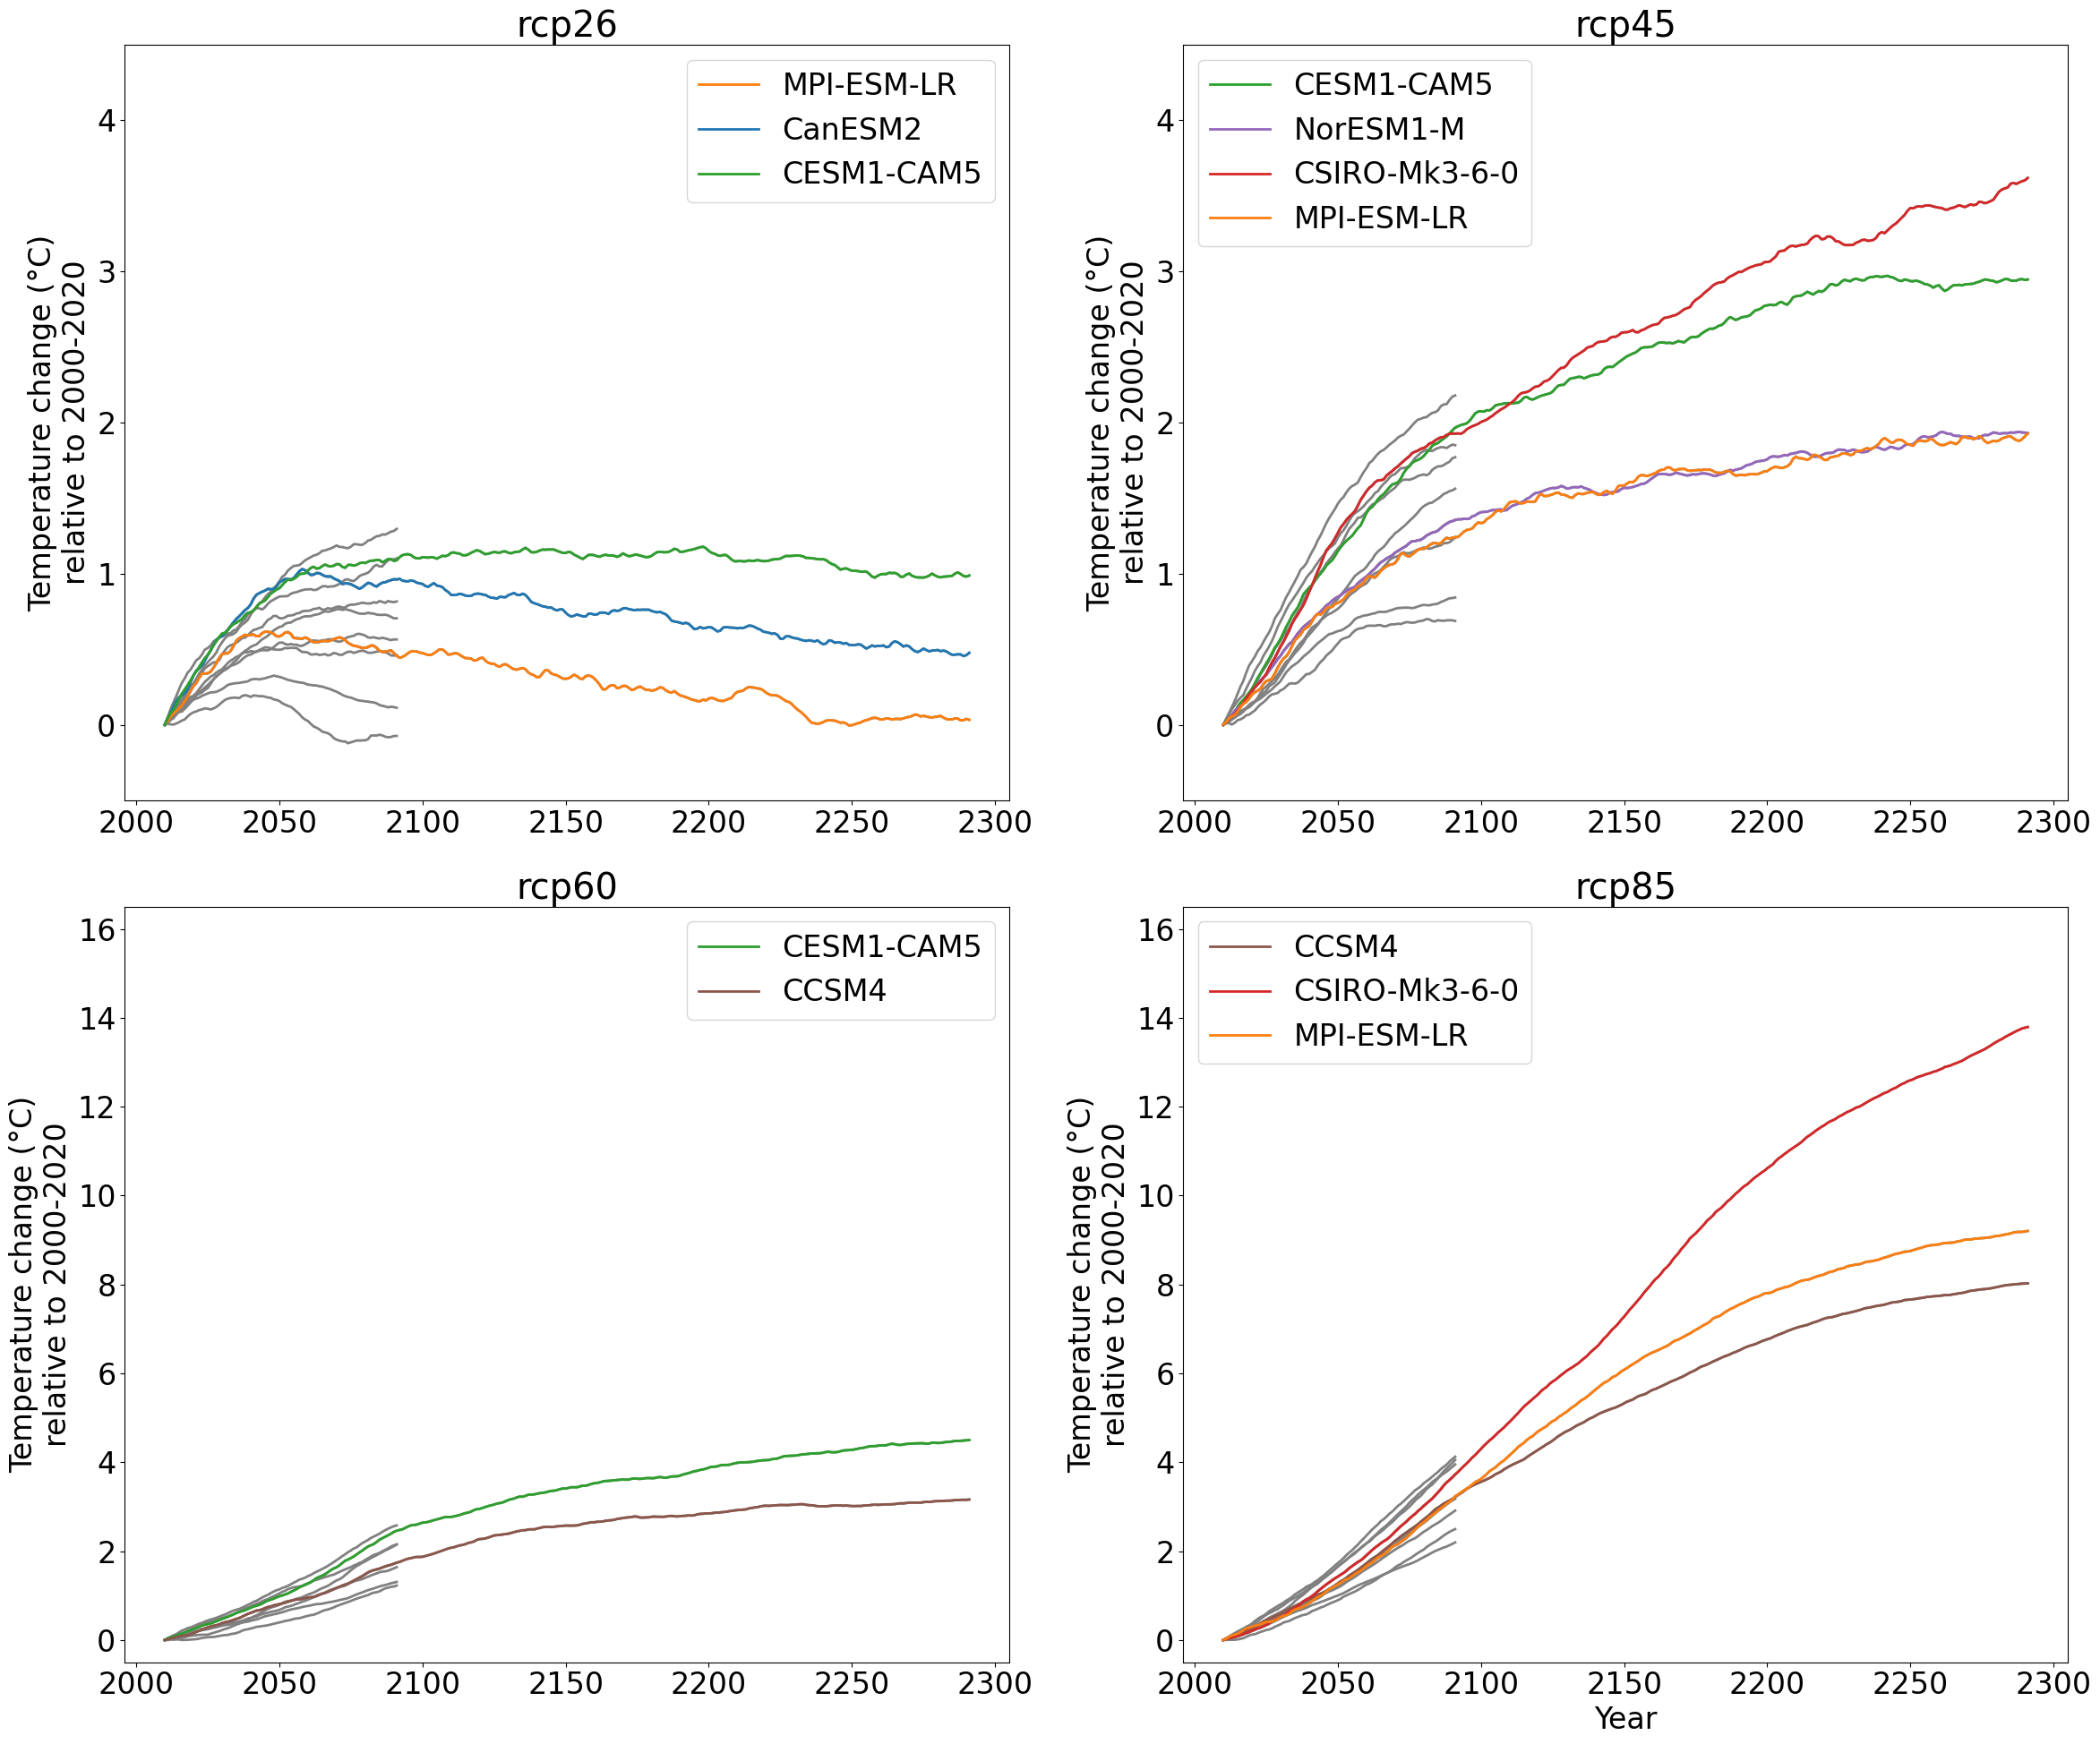

In [14]:
fig,axs = plt.subplots(2,2,figsize=(24,20))
axs = axs.flatten()
plt.rc('font', size=24)
for ax,rcp in  zip(axs,['rcp26', 'rcp45', 'rcp60','rcp85']):
    gcms_cmip5_2300_over = gcms_cmip5.loc[(gcms_cmip5.rcp ==rcp) & (gcms_cmip5['var'] =='tas')]
    for f in gcms_cmip5_2300_over.index:
        dtas_annual = xr.open_dataset(gcms_cmip5_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('2000',
                                                                      '2300')).tas.groupby('time.year').mean()
        weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()

        # get the global means for every month:
        global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=20, center=True).mean()
        ax.plot(global_dtas.year, global_dtas-global_dtas.sel(year=2010), lw=2,
                color= 'grey')
ax.set_xlabel('Year')
     
for ax,rcp in  zip(axs,['rcp26', 'rcp45', 'rcp60','rcp85']):
    gcms_cmip5_2300_over = gcms_cmip5_2300.loc[(gcms_cmip5_2300.rcp==rcp) & (gcms_cmip5_2300['var'] =='tas')]
    for f in gcms_cmip5_2300_over.index:
        dtas_annual = xr.open_dataset(gcms_cmip5_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('2000',
                                                                      '2300')).tas.groupby('time.year').mean()
        weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()

        # get the global means for every month:
        global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=20, center=True).mean()
        ax.plot(global_dtas.year, global_dtas-global_dtas.sel(year=2010), lw=2,
                label=gcms_cmip5_2300_over.loc[f].gcm, 
                color= gcm_c5[gcms_cmip5_2300_over.loc[f].gcm])
    if rcp in ['rcp26', 'rcp45']:
        ax.set_ylim([-0.5,4.5])
    else:
        ax.set_ylim([-0.5,16.5])
    ax.set_ylabel('Temperature change (°C)\nrelative to 2000-2020')
    ax.legend()
    ax.set_title(rcp)
    
ax.set_xlabel('Year')

plt.tight_layout()
#plt.savefig('gcm_global_temp_change_cmip5_ipcc_ar6_def.png')

### Create plots relative to preindustrial levels and showing the lines dependent on 2071-2100 warming 

In [15]:
pd_temp_ch_2100_2300_cmip5 = pd.read_csv('Global_mean_temp_deviation_2071_2100_2081_2100_2271_2300_2281_2300_rel_1850_1900_cmip5_gcms_ipcc_ar6_def.csv', index_col=0)
pd_temp_ch_2100_2300_cmip6 = pd.read_csv('Global_mean_temp_deviation_2071_2100_2081_2100_2271_2300_2281_2300_rel_1850_1900_cmip6_gcms_ipcc_ar6_def.csv', index_col=0)

In [16]:
pd_temp_ch_2100_2300_both = pd.concat([pd_temp_ch_2100_2300_cmip5, pd_temp_ch_2100_2300_cmip6])

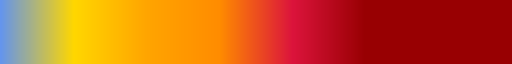

In [17]:
from matplotlib.colors import LinearSegmentedColormap

colors_temp4_l = ['cornflowerblue', 'gold', 'orange', 'darkorange', 'crimson', '#980002', '#980002', '#980002']
cmap_blue_orange = LinearSegmentedColormap.from_list('bins_100',colors_temp4_l, N=1000)
cmap_blue_orange

In [18]:
pd_temp_ch_only_2300_both = pd_temp_ch_2100_2300_both.loc[pd_temp_ch_2100_2300_both['global_temp_ch_2271-2300_preindustrial'].dropna().index]

**Let's scale according to 2300 GCMs**

In [19]:
from sklearn.preprocessing import MinMaxScaler
data_temp = pd_temp_ch_only_2300_both['global_temp_ch_2071-2100_preindustrial'].values.reshape(1,-1).T
scaler = MinMaxScaler()
scaler.fit(data_temp)

MinMaxScaler()

In [20]:
gcms_cmip5_2300 = pd.read_csv('/home/www/oggm/cmip5-ng/all_gcm_list_2300.csv', index_col=0).reset_index(drop=True) 
gcms_cmip5 = pd.read_csv('/home/www/oggm/cmip5-ng/all_gcm_list.csv', index_col=0).reset_index(drop=True)   
# we have used the regular interpolationgcms_cmip5.loc[gcms_cmip5.interpolation == '_g025']
gcms_rcps = []
for ind in gcms_cmip5.loc[gcms_cmip5['var']=='pr'].index:
    gcms_rcps.append(f'{gcms_cmip5.loc[ind].gcm}_{gcms_cmip5.loc[ind].rcp}')
gcm_c5 = {}
for e,gcm in enumerate(['CanESM2', 'MPI-ESM-LR', 'CESM1-CAM5', 'CSIRO-Mk3-6-0',
       'NorESM1-M', 'CCSM4']):
    gcm_c5[gcm] = f'C{e}'

***only show the 2300 GCMs**

ssp126 5
ssp534-over 3
ssp585 5
rcp26 3
rcp45 4
rcp60 2
rcp85 3


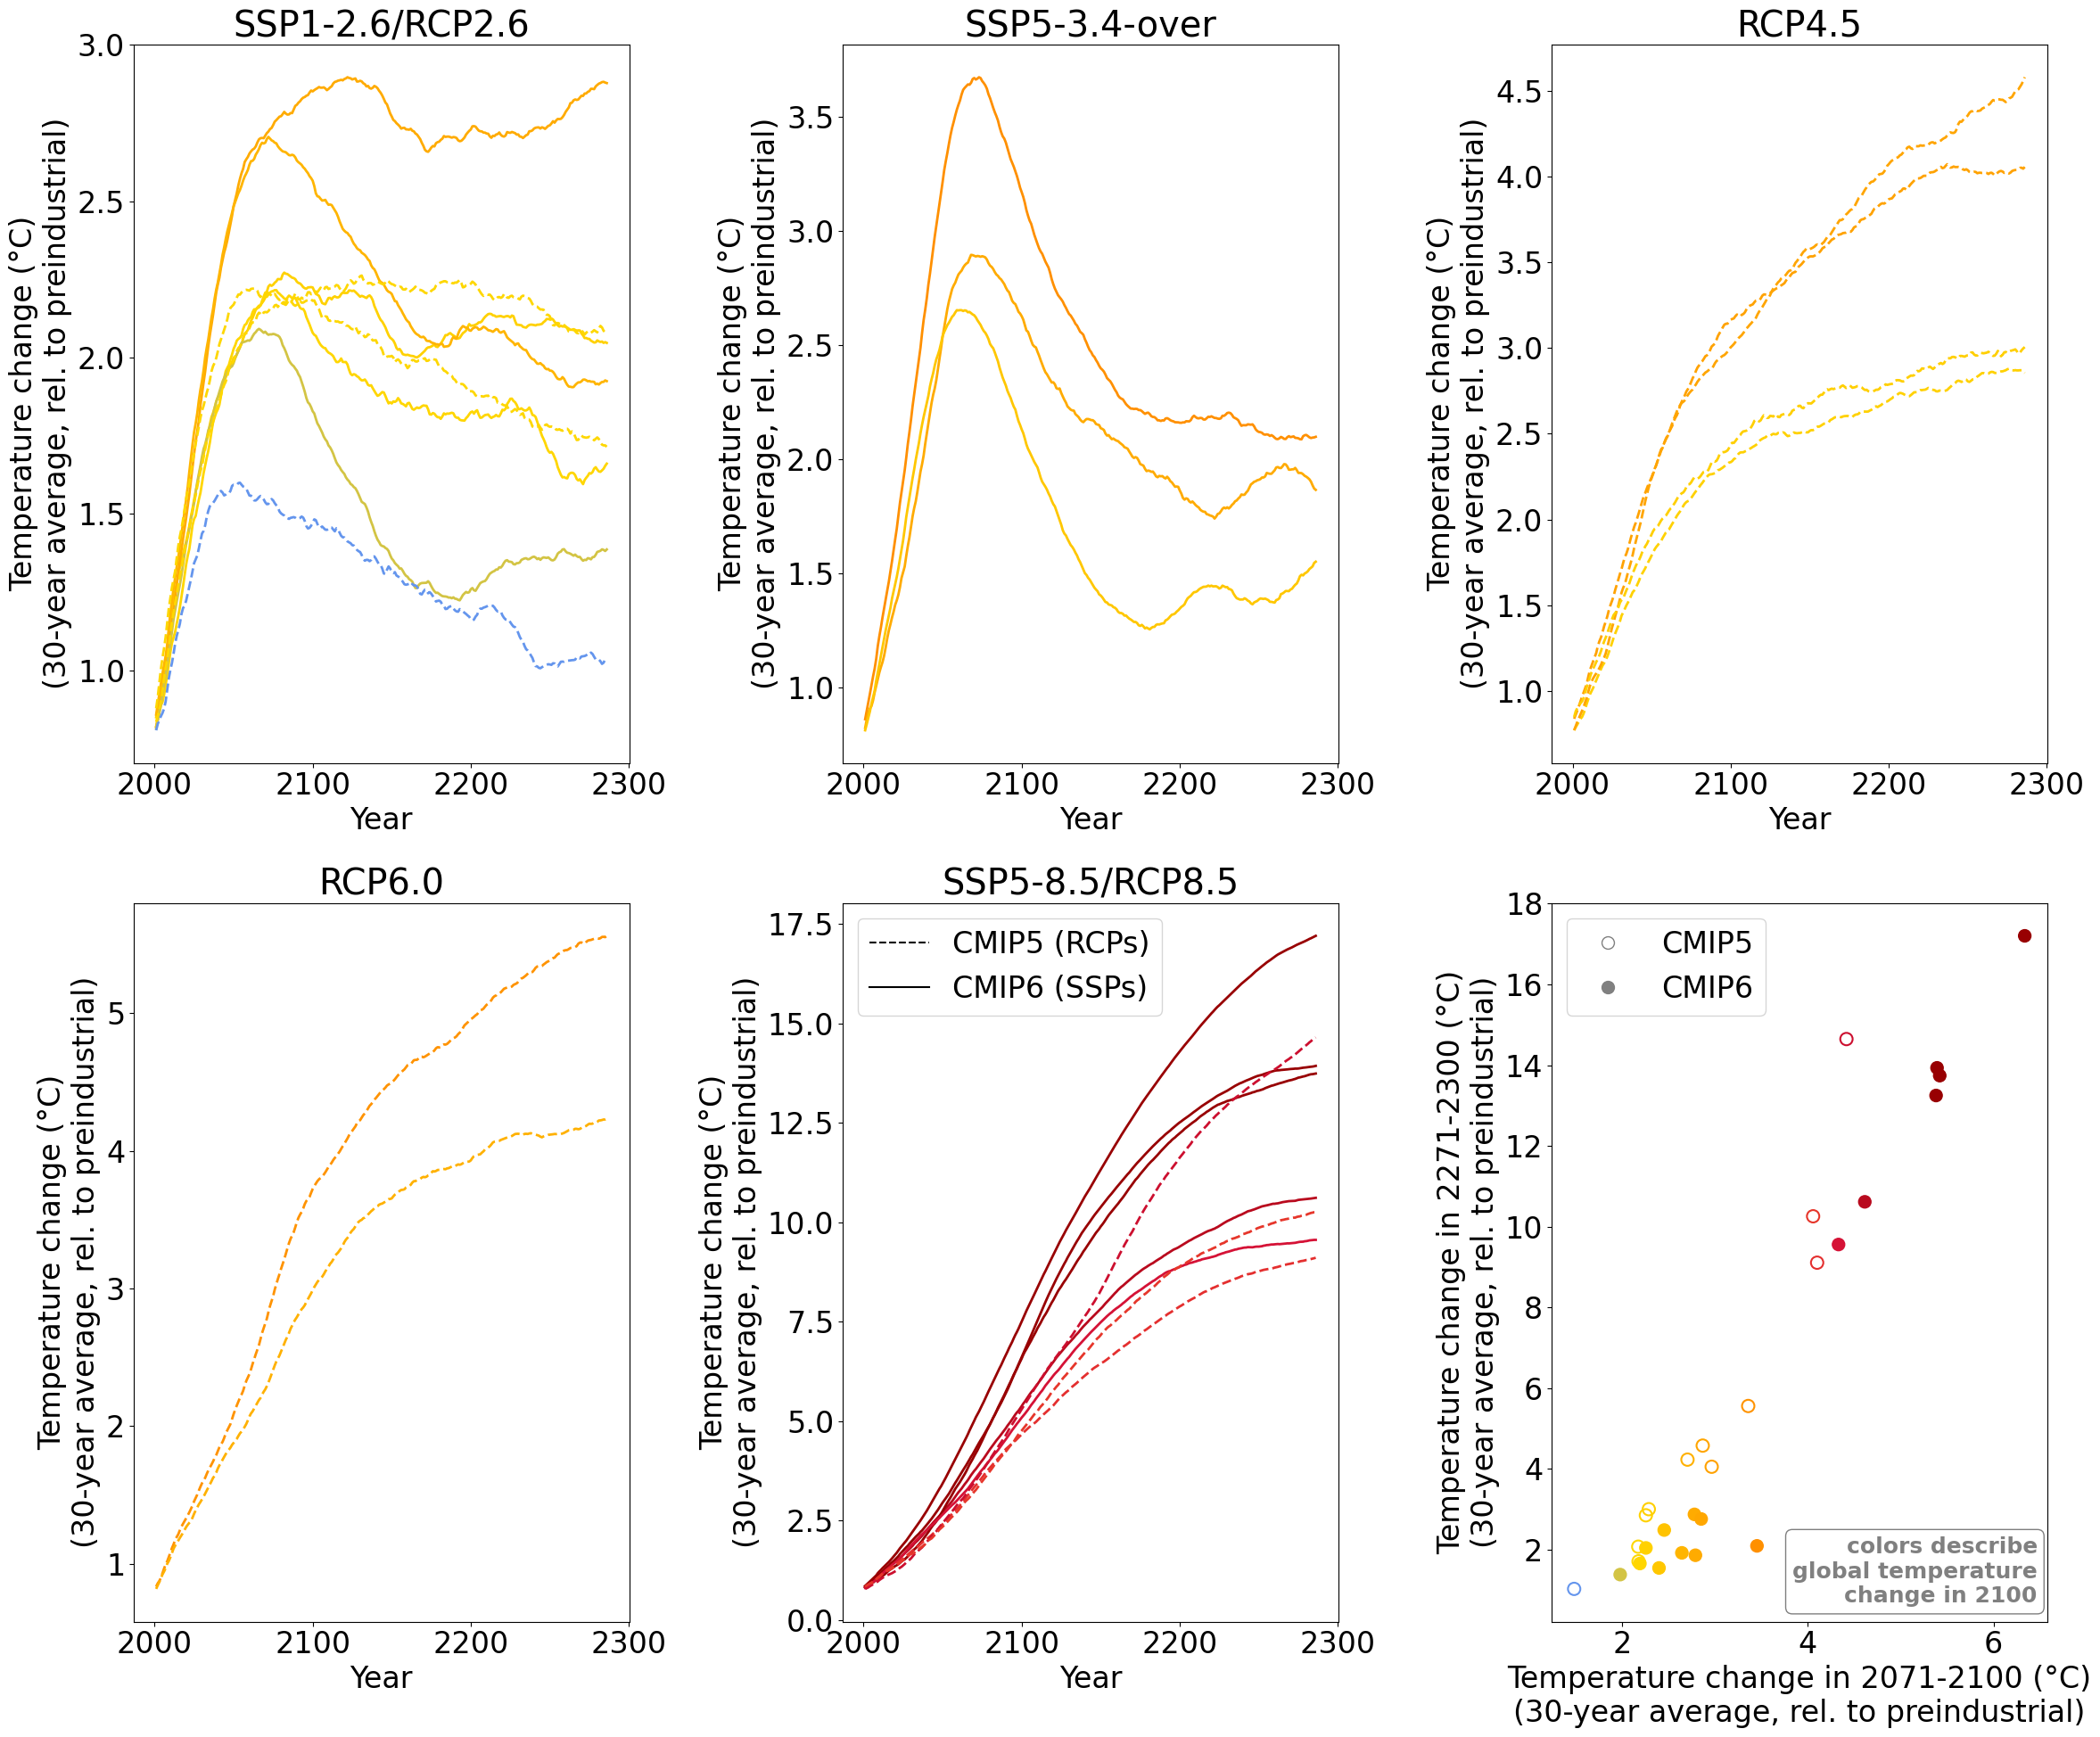

In [24]:
from matplotlib.lines import Line2D
line_cmip5 = Line2D([0], [0], label='CMIP5 (RCPs)', ls='--', color='k')
line_cmip6 = Line2D([0], [0], label='CMIP6 (SSPs)', ls='-', color='k')

fig,axs = plt.subplots(2,3,figsize=(24,20))
axs = axs.flatten()
plt.rc('font', size=24)
for ssp in  ['ssp126','ssp534-over','ssp585']:
    if '26' in ssp:
        ax = axs[0]
        ax.set_title('SSP1-2.6/RCP2.6')
    elif '534-over' in ssp:
        ax = axs[1]
        ax.set_title('SSP5-3.4-over')
    elif '85' in ssp:
        ax = axs[4]
        ax.set_title('SSP5-8.5/RCP8.5')
    gcms_cmip6_sel = gcms_cmip6.loc[gcms_cmip6.y1>2299]
    gcms_cmip6_2300_over = gcms_cmip6_sel.loc[(gcms_cmip6_sel.ssp ==ssp) & (gcms_cmip6_sel['var'] =='tas')]
    print(ssp, len(gcms_cmip6_2300_over))

    for f in gcms_cmip6_2300_over.index:
        dtas_annual = xr.open_dataset(gcms_cmip6_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('1986','2300')).tas.groupby('time.year').mean()

        weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()
        global_dtas_per_year = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')
        avg_1986_2005 = global_dtas_per_year.sel(year=slice('1986','2005')).mean().values
        avg_2071_2100 = global_dtas_per_year.sel(year=slice('2071','2100')).mean().values
        temperature_increase_2071_2100_rel_preindustrial = avg_2071_2100- avg_1986_2005 + past_warming

        # get the global means for every month:
        global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=30, center=True).mean()
        color= cmap_blue_orange(scaler.transform(temperature_increase_2071_2100_rel_preindustrial.reshape(-1,1))).flatten()

        ax.plot(global_dtas.year, global_dtas - avg_1986_2005 + past_warming, lw=2,
                color= color)

for rcp in  ['rcp26', 'rcp45', 'rcp60','rcp85']:
    if '26' in rcp:
        ax = axs[0]
        ax.set_title('SSP1-2.6/RCP2.6')
    elif '45' in rcp:
        ax = axs[2]
        ax.set_title('RCP4.5')
    elif '60' in rcp:
        ax = axs[3]
        ax.set_title('RCP6.0')
    elif '85' in rcp:
        ax = axs[4]
        
    gcms_cmip5_sel = gcms_cmip5.loc[gcms_cmip5.y1>2299]
    gcms_cmip5_2300_over = gcms_cmip5_sel.loc[(gcms_cmip5_sel.rcp ==rcp) & (gcms_cmip5_sel['var'] =='tas')]
    print(rcp, len(gcms_cmip5_2300_over))
    for f in gcms_cmip5_2300_over.index:
        dtas_annual = xr.open_dataset(gcms_cmip5_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('1986',
                                                                      '2300')).tas.groupby('time.year').mean()
        weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()

        global_dtas_per_year = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')
        avg_1986_2005 = global_dtas_per_year.sel(year=slice('1986','2005')).mean().values
        avg_2071_2100 = global_dtas_per_year.sel(year=slice('2071','2100')).mean().values
        temperature_increase_2071_2100_rel_preindustrial = avg_2071_2100- avg_1986_2005 + past_warming

        # get the global means for every month:
        global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=30, center=True).mean()
        color= cmap_blue_orange(scaler.transform(temperature_increase_2071_2100_rel_preindustrial.reshape(-1,1))).flatten()

        #ax.plot(global_dtas.year, global_dtas-global_dtas.sel(year=2010), lw=2,
        #        color= 'grey')
        ax.plot(global_dtas.year, global_dtas - avg_1986_2005 + past_warming, lw=2, ls = '--',
                color= color)
        
        if ax == axs[-2]:    
            ax.legend(handles=[line_cmip5,line_cmip6])
for ax in axs[:-1]:
    ax.set_ylabel('Temperature change (°C)\n(30-year average, rel. to preindustrial)')
    ax.set_xlabel('Year')

    
ax = axs[-1]
from matplotlib.markers import MarkerStyle
ind_cmip5 = pd_temp_ch_only_2300_both['rcp'].dropna().index

ax.scatter(pd_temp_ch_only_2300_both.loc[ind_cmip5,'global_temp_ch_2071-2100_preindustrial'], pd_temp_ch_only_2300_both.loc[ind_cmip5,'global_temp_ch_2271-2300_preindustrial'],
            color = cmap_blue_orange(scaler.transform(pd_temp_ch_only_2300_both.loc[ind_cmip5,'global_temp_ch_2071-2100_preindustrial'].values.reshape(-1,1))),
            s = 100, cmap =cmap_blue_orange, marker=MarkerStyle('o', fillstyle='none'))#c = color, cmap = )

ind_cmip6 = pd_temp_ch_only_2300_both['ssp'].dropna().index
ax.scatter(pd_temp_ch_only_2300_both.loc[ind_cmip6,'global_temp_ch_2071-2100_preindustrial'], pd_temp_ch_only_2300_both.loc[ind_cmip6,'global_temp_ch_2271-2300_preindustrial'],
            color = cmap_blue_orange(scaler.transform(pd_temp_ch_only_2300_both.loc[ind_cmip6,'global_temp_ch_2071-2100_preindustrial'].values.reshape(-1,1))),
            s = 100, cmap =cmap_blue_orange, marker=MarkerStyle('o', fillstyle='full'))#c = color, cmap = )

points_cmip5 = Line2D([0], [0], label='CMIP5', marker=MarkerStyle('o', fillstyle='none'), markersize=10, lw=0, color='grey',
          fillstyle='none')
points_cmip6 = Line2D([0], [0], label='CMIP6', marker=MarkerStyle('o', fillstyle='full'), markersize=10, lw=0, color='grey',
          )
ax.legend(handles=[points_cmip5,points_cmip6])
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

ax.text(0.98,0.02, 'colors describe\nglobal temperature\nchange in 2100',
                                transform=ax.transAxes,
                                verticalalignment="bottom", bbox=props, horizontalalignment='right',
                                color='grey', alpha=1, fontweight = 'bold', fontsize=18)

#plt.colorbar()
ax.set_xlabel('Temperature change in 2071-2100 (°C)\n(30-year average, rel. to preindustrial)')
ax.set_ylabel('Temperature change in 2271-2300 (°C)\n(30-year average, rel. to preindustrial)')

plt.tight_layout()
plt.savefig('gcm_global_colors_by_temp_change_2300_ipcc_ar6_def.png')
plt.savefig('gcm_global_colors_by_temp_change_2300_ipcc_ar6_def.png')


**Show until 2100 and until 2300**

ssp126 17
ssp534-over 4
ssp585 19
rcp26 13
rcp45 14
rcp60 9
rcp85 13


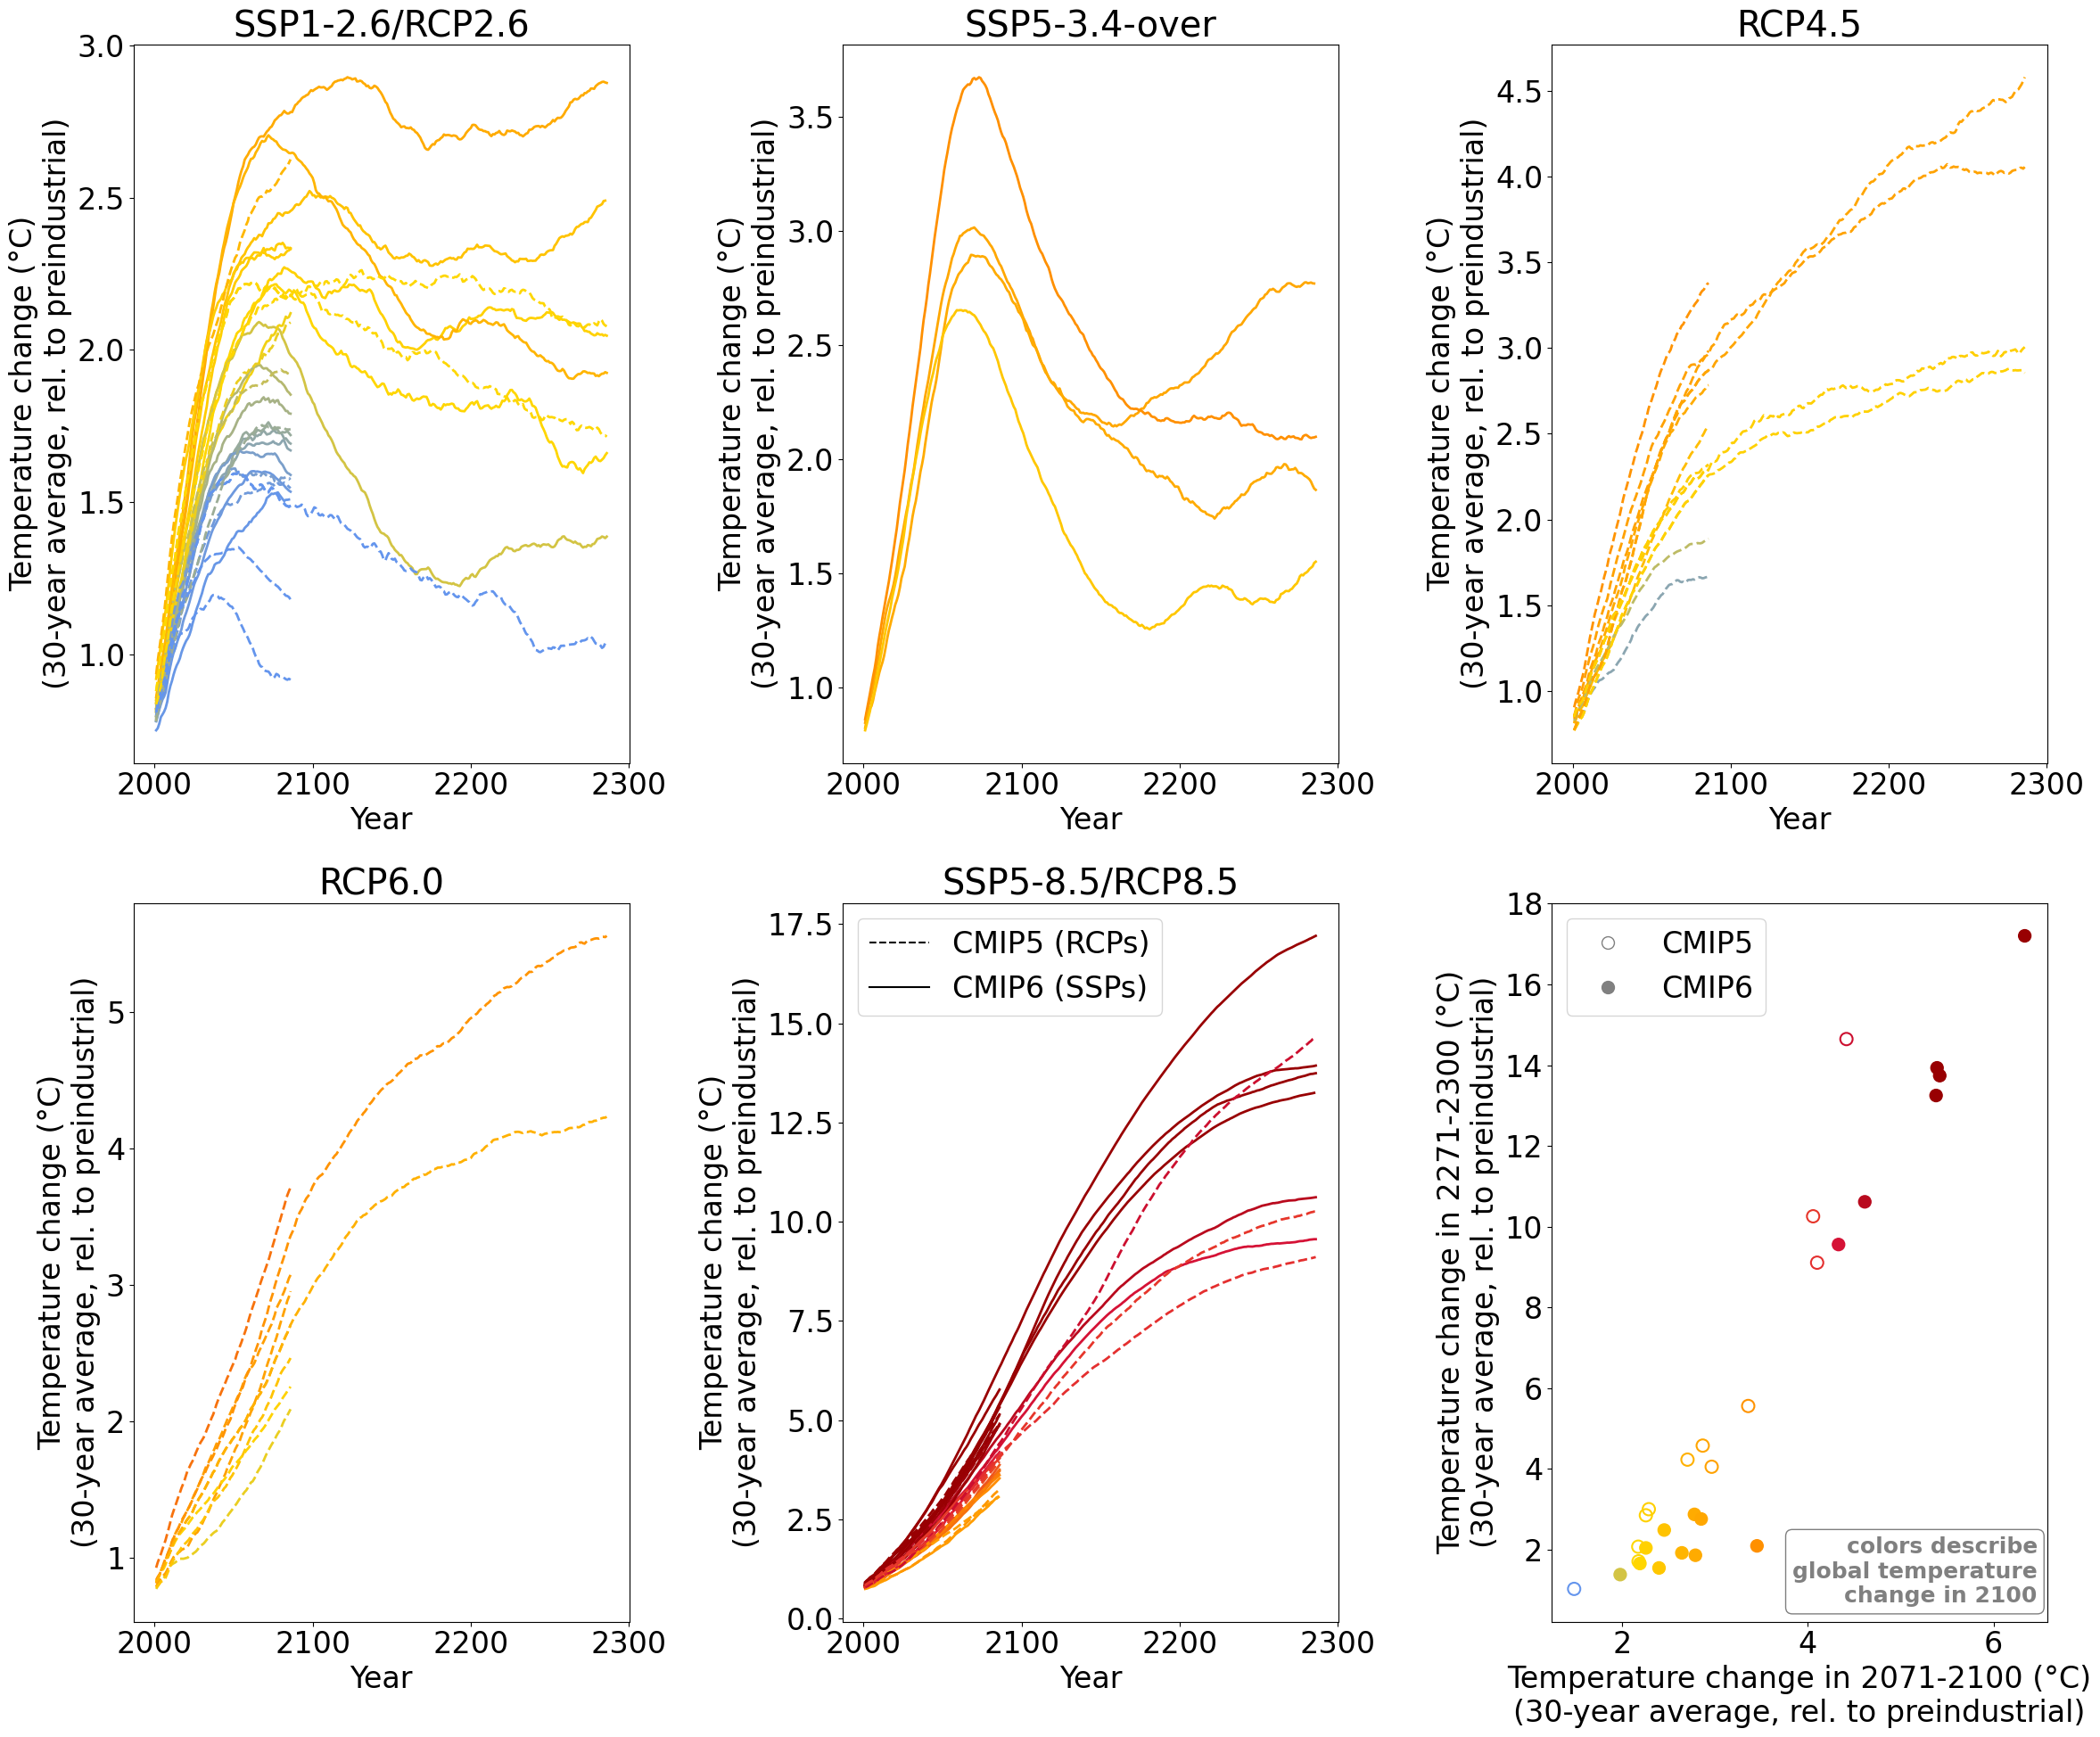

In [22]:
from matplotlib.lines import Line2D
line_cmip5 = Line2D([0], [0], label='CMIP5 (RCPs)', ls='--', color='k')
line_cmip6 = Line2D([0], [0], label='CMIP6 (SSPs)', ls='-', color='k')

fig,axs = plt.subplots(2,3,figsize=(24,20))
axs = axs.flatten()
plt.rc('font', size=24)
for ssp in  ['ssp126','ssp534-over','ssp585']:
    if '26' in ssp:
        ax = axs[0]
        ax.set_title('SSP1-2.6/RCP2.6')
    elif '534-over' in ssp:
        ax = axs[1]
        ax.set_title('SSP5-3.4-over')
    elif '85' in ssp:
        ax = axs[4]
        ax.set_title('SSP5-8.5/RCP8.5')
    gcms_cmip6_sel = gcms_cmip6#.loc[gcms_cmip6.y1>2299]
    gcms_cmip6_2300_over = gcms_cmip6_sel.loc[(gcms_cmip6_sel.ssp ==ssp) & (gcms_cmip6_sel['var'] =='tas')]
    print(ssp, len(gcms_cmip6_2300_over))

    for f in gcms_cmip6_2300_over.index:
        dtas_annual = xr.open_dataset(gcms_cmip6_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('1986','2300')).tas.groupby('time.year').mean()

        weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()
        global_dtas_per_year = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')
        avg_1986_2005 = global_dtas_per_year.sel(year=slice('1986','2005')).mean().values
        avg_2071_2100 = global_dtas_per_year.sel(year=slice('2071','2100')).mean().values
        temperature_increase_2071_2100_rel_preindustrial = avg_2071_2100- avg_1986_2005 + past_warming

        # get the global means for every month:
        global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=30, center=True).mean()
        color= cmap_blue_orange(scaler.transform(temperature_increase_2071_2100_rel_preindustrial.reshape(-1,1))).flatten()

        ax.plot(global_dtas.year, global_dtas - avg_1986_2005 + past_warming, lw=2,
                color= color)

for rcp in  ['rcp26', 'rcp45', 'rcp60','rcp85']:
    if '26' in rcp:
        ax = axs[0]
        ax.set_title('SSP1-2.6/RCP2.6')
    elif '45' in rcp:
        ax = axs[2]
        ax.set_title('RCP4.5')
    elif '60' in rcp:
        ax = axs[3]
        ax.set_title('RCP6.0')
    elif '85' in rcp:
        ax = axs[4]
        
    gcms_cmip5_sel = gcms_cmip5#.loc[gcms_cmip5.y1>2299]
    gcms_cmip5_2300_over = gcms_cmip5_sel.loc[(gcms_cmip5_sel.rcp ==rcp) & (gcms_cmip5_sel['var'] =='tas')]
    print(rcp, len(gcms_cmip5_2300_over))
    for f in gcms_cmip5_2300_over.index:
        dtas_annual = xr.open_dataset(gcms_cmip5_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('1986',
                                                                      '2300')).tas.groupby('time.year').mean()
        weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()

        global_dtas_per_year = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')
        avg_1986_2005 = global_dtas_per_year.sel(year=slice('1986','2005')).mean().values
        avg_2071_2100 = global_dtas_per_year.sel(year=slice('2071','2100')).mean().values
        temperature_increase_2071_2100_rel_preindustrial = avg_2071_2100- avg_1986_2005 + past_warming

        # get the global means for every month:
        global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=30, center=True).mean()
        color= cmap_blue_orange(scaler.transform(temperature_increase_2071_2100_rel_preindustrial.reshape(-1,1))).flatten()

        #ax.plot(global_dtas.year, global_dtas-global_dtas.sel(year=2010), lw=2,
        #        color= 'grey')
        ax.plot(global_dtas.year, global_dtas - avg_1986_2005 + past_warming, lw=2, ls = '--',
                color= color)
        
        if ax == axs[-2]:    
            ax.legend(handles=[line_cmip5,line_cmip6])
for ax in axs[:-1]:
    ax.set_ylabel('Temperature change (°C)\n(30-year average, rel. to preindustrial)')
    ax.set_xlabel('Year')

    
ax = axs[-1]
from matplotlib.markers import MarkerStyle
ind_cmip5 = pd_temp_ch_only_2300_both['rcp'].dropna().index

ax.scatter(pd_temp_ch_only_2300_both.loc[ind_cmip5,'global_temp_ch_2071-2100_preindustrial'], pd_temp_ch_only_2300_both.loc[ind_cmip5,'global_temp_ch_2271-2300_preindustrial'],
            color = cmap_blue_orange(scaler.transform(pd_temp_ch_only_2300_both.loc[ind_cmip5,'global_temp_ch_2071-2100_preindustrial'].values.reshape(-1,1))),
            s = 100, cmap =cmap_blue_orange, marker=MarkerStyle('o', fillstyle='none'))#c = color, cmap = )

ind_cmip6 = pd_temp_ch_only_2300_both['ssp'].dropna().index
ax.scatter(pd_temp_ch_only_2300_both.loc[ind_cmip6,'global_temp_ch_2071-2100_preindustrial'], pd_temp_ch_only_2300_both.loc[ind_cmip6,'global_temp_ch_2271-2300_preindustrial'],
            color = cmap_blue_orange(scaler.transform(pd_temp_ch_only_2300_both.loc[ind_cmip6,'global_temp_ch_2071-2100_preindustrial'].values.reshape(-1,1))),
            s = 100, cmap =cmap_blue_orange, marker=MarkerStyle('o', fillstyle='full'))#c = color, cmap = )

points_cmip5 = Line2D([0], [0], label='CMIP5', marker=MarkerStyle('o', fillstyle='none'), markersize=10, lw=0, color='grey',
          fillstyle='none')
points_cmip6 = Line2D([0], [0], label='CMIP6', marker=MarkerStyle('o', fillstyle='full'), markersize=10, lw=0, color='grey',
          fillstyle='none')
ax.legend(handles=[points_cmip5,points_cmip6])
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

ax.text(0.98,0.02, 'colors describe\nglobal temperature\nchange in 2100',
                                transform=ax.transAxes,
                                verticalalignment="bottom", bbox=props, horizontalalignment='right',
                                color='grey', alpha=1, fontweight = 'bold', fontsize=18)

#plt.colorbar()
ax.set_xlabel('Temperature change in 2071-2100 (°C)\n(30-year average, rel. to preindustrial)')
ax.set_ylabel('Temperature change in 2271-2300 (°C)\n(30-year average, rel. to preindustrial)')

plt.tight_layout()
plt.savefig('gcm_global_colors_by_temp_change_2100_2300_ipcc_ar6_def.png')
plt.savefig('gcm_global_colors_by_temp_change_2100_2300_ipcc_ar6_def.png')


**Only show those until 2100 (but at the moment it uses the same cmap)**

ssp126 17
ssp534-over 4
ssp585 19
rcp26 13
rcp45 14
rcp60 9
rcp85 13


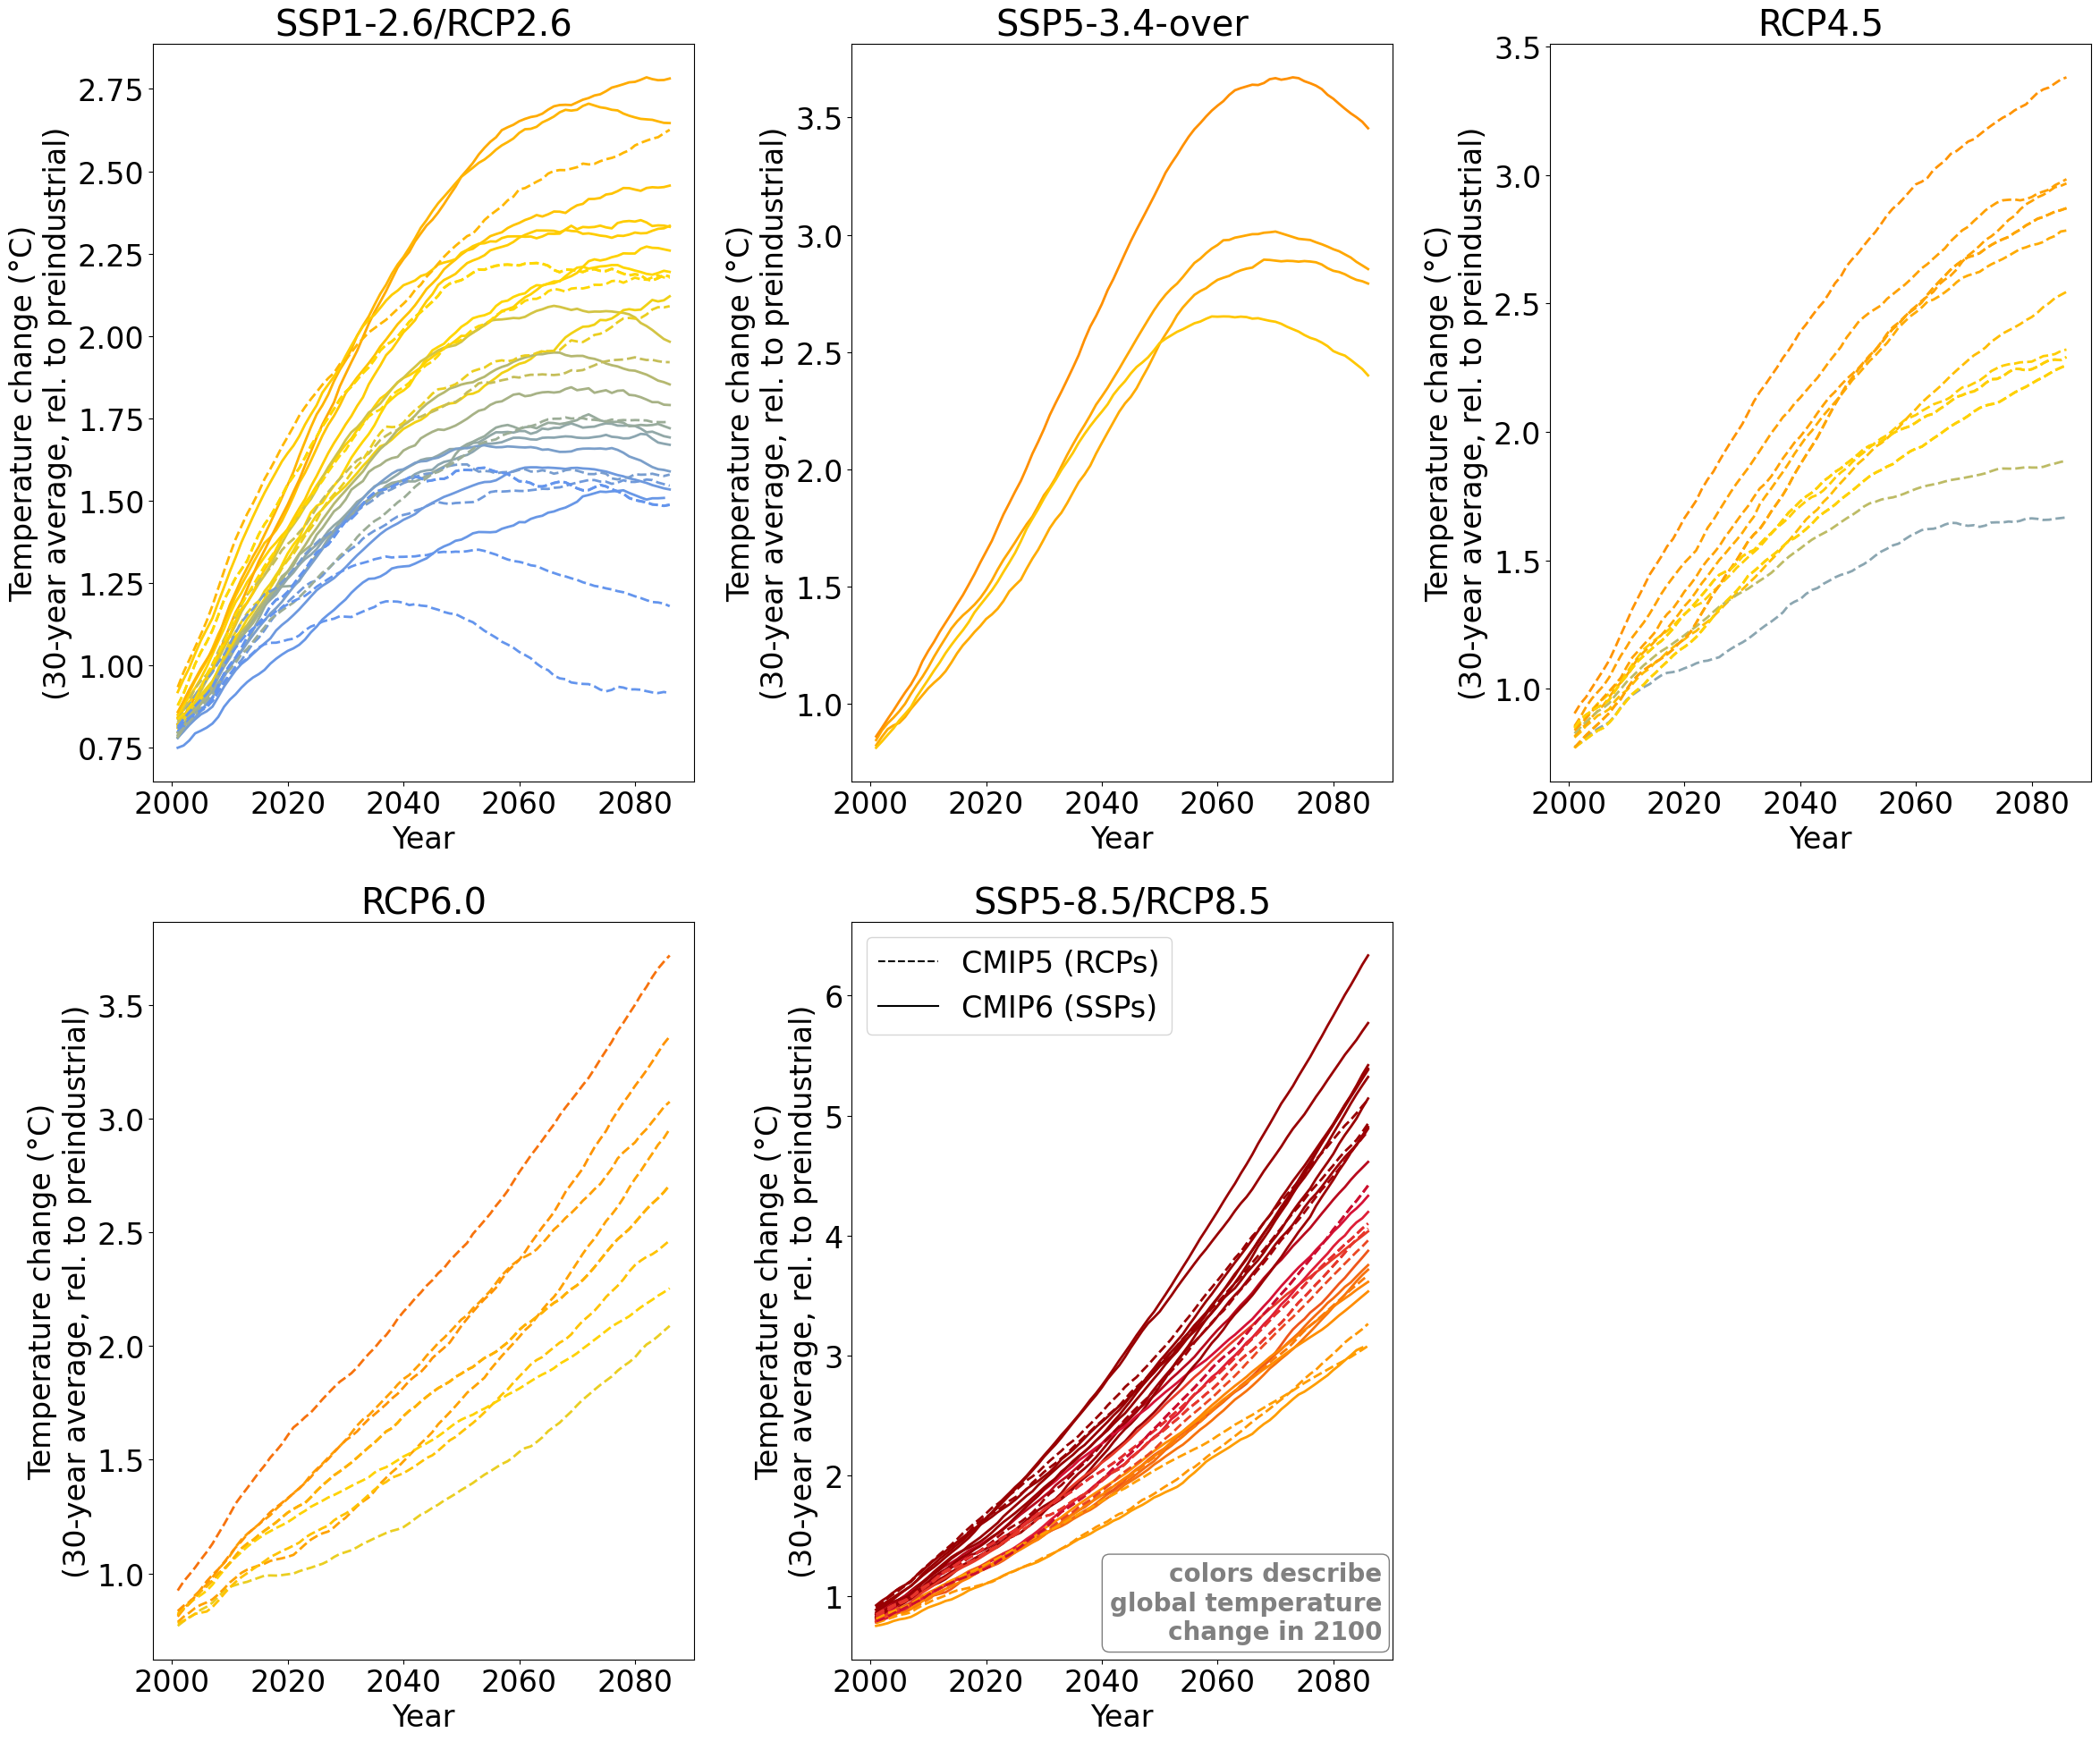

In [23]:
from matplotlib.lines import Line2D
line_cmip5 = Line2D([0], [0], label='CMIP5 (RCPs)', ls='--', color='k')
line_cmip6 = Line2D([0], [0], label='CMIP6 (SSPs)', ls='-', color='k')

fig,axs = plt.subplots(2,3,figsize=(24,20))
axs = axs.flatten()
plt.rc('font', size=24)
for ssp in  ['ssp126','ssp534-over','ssp585']:
    if '26' in ssp:
        ax = axs[0]
        ax.set_title('SSP1-2.6/RCP2.6')
    elif '534-over' in ssp:
        ax = axs[1]
        ax.set_title('SSP5-3.4-over')
    elif '85' in ssp:
        ax = axs[4]
        ax.set_title('SSP5-8.5/RCP8.5')
    gcms_cmip6_sel = gcms_cmip6#.loc[gcms_cmip6.y1<=2100]
    gcms_cmip6_2300_over = gcms_cmip6_sel.loc[(gcms_cmip6_sel.ssp ==ssp) & (gcms_cmip6_sel['var'] =='tas')]
    print(ssp, len(gcms_cmip6_2300_over))

    for f in gcms_cmip6_2300_over.index:
        dtas_annual = xr.open_dataset(gcms_cmip6_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('1986','2100')).tas.groupby('time.year').mean()

        weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()
        global_dtas_per_year = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')
        avg_1986_2005 = global_dtas_per_year.sel(year=slice('1986','2005')).mean().values
        avg_2071_2100 = global_dtas_per_year.sel(year=slice('2071','2100')).mean().values
        temperature_increase_2071_2100_rel_preindustrial = avg_2071_2100- avg_1986_2005 + past_warming

        # get the global means for every month:
        global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=30, center=True).mean()
        color= cmap_blue_orange(scaler.transform(temperature_increase_2071_2100_rel_preindustrial.reshape(-1,1))).flatten()

        ax.plot(global_dtas.year, global_dtas - avg_1986_2005 + past_warming, lw=2,
                color= color)

for rcp in  ['rcp26', 'rcp45', 'rcp60','rcp85']:
    if '26' in rcp:
        ax = axs[0]
        ax.set_title('SSP1-2.6/RCP2.6')
    elif '45' in rcp:
        ax = axs[2]
        ax.set_title('RCP4.5')
    elif '60' in rcp:
        ax = axs[3]
        ax.set_title('RCP6.0')
    elif '85' in rcp:
        ax = axs[4]
        
    gcms_cmip5_sel = gcms_cmip5#.loc[gcms_cmip5.y1<=2100]
    gcms_cmip5_2300_over = gcms_cmip5_sel.loc[(gcms_cmip5_sel.rcp ==rcp) & (gcms_cmip5_sel['var'] =='tas')]
    print(rcp, len(gcms_cmip5_2300_over))
    for f in gcms_cmip5_2300_over.index:
        dtas_annual = xr.open_dataset(gcms_cmip5_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('1986',
                                                                      '2100')).tas.groupby('time.year').mean()
        weight = np.cos(np.deg2rad(dtas_annual.lat))
        weight = weight / weight.sum()

        global_dtas_per_year = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat')
        avg_1986_2005 = global_dtas_per_year.sel(year=slice('1986','2005')).mean().values
        avg_2071_2100 = global_dtas_per_year.sel(year=slice('2071','2100')).mean().values
        temperature_increase_2071_2100_rel_preindustrial = avg_2071_2100- avg_1986_2005 + past_warming

        # get the global means for every month:
        global_dtas = (dtas_annual.mean(dim='lon') * weight).sum(dim='lat').rolling(year=30, center=True).mean()
        color= cmap_blue_orange(scaler.transform(temperature_increase_2071_2100_rel_preindustrial.reshape(-1,1))).flatten()

        #ax.plot(global_dtas.year, global_dtas-global_dtas.sel(year=2010), lw=2,
        #        color= 'grey')
        ax.plot(global_dtas.year, global_dtas - avg_1986_2005 + past_warming, lw=2, ls = '--',
                color= color)
        
        if ax == axs[-2]:    
            ax.legend(handles=[line_cmip5,line_cmip6])
for ax in axs[:-1]:
    ax.set_ylabel('Temperature change (°C)\n(30-year average, rel. to preindustrial)')
    ax.set_xlabel('Year')

    
ax = axs[-2]
from matplotlib.markers import MarkerStyle
#ind_cmip5 = pd_temp_ch_only_2300_both['rcp'].dropna().index
#ax.scatter(pd_temp_ch_only_2300_both.loc[ind_cmip5,'global_temp_ch_2071-2100_preindustrial'], pd_temp_ch_only_2300_both.loc[ind_cmip5,'global_temp_ch_2271-2300_preindustrial'],
#            color = cmap_blue_orange(scaler.transform(pd_temp_ch_only_2300_both.loc[ind_cmip5,'global_temp_ch_2071-2100_preindustrial'].values.reshape(-1,1))),
#            s = 100, cmap =cmap_blue_orange, marker=MarkerStyle('o', fillstyle='none'))#c = color, cmap = )

#ind_cmip6 = pd_temp_ch_only_2300_both['ssp'].dropna().index
#ax.scatter(pd_temp_ch_only_2300_both.loc[ind_cmip6,'global_temp_ch_2071-2100_preindustrial'], pd_temp_ch_only_2300_both.loc[ind_cmip6,'global_temp_ch_2271-2300_preindustrial'],
#            color = cmap_blue_orange(scaler.transform(pd_temp_ch_only_2300_both.loc[ind_cmip6,'global_temp_ch_2071-2100_preindustrial'].values.reshape(-1,1))),
#            s = 100, cmap =cmap_blue_orange, marker=MarkerStyle('o', fillstyle='full'))#c = color, cmap = )

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

ax.text(0.98,0.02, 'colors describe\nglobal temperature\nchange in 2100',
                                transform=ax.transAxes,
                                verticalalignment="bottom", bbox=props, horizontalalignment='right',
                                color='grey', alpha=1, fontweight = 'bold', fontsize=20)

axs[-1].remove()

plt.tight_layout()
plt.savefig('gcm_global_colors_by_temp_change_2100_ipcc_ar6_def.png')
plt.savefig('gcm_global_colors_by_temp_change_2100_ipcc_ar6_def.png')


**TODO: extract local RGI glacier region climate**
- problem so far, somehow, I don't manage to define correctly the lon_bins
- another issue: every GCM has a different interpolation ... 

In [10]:
import oggm
frgi = oggm.utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5')
odf = pd.read_hdf(frgi, index_col=0)


**Here is just to extract the nearest gridpoint of the glacier with the largest area ....**

In [57]:
gcms_cmip6_sel = gcms_cmip6.loc[gcms_cmip6.y1>=2299]
ssp = 'ssp126'

gcms_cmip6_2300_over = gcms_cmip6_sel.loc[(gcms_cmip6_sel.ssp ==ssp) & (gcms_cmip6_sel['var'] =='tas')]
print(ssp, len(gcms_cmip6_2300_over))

dtas_annual_d_ssp126 = {}
for f in gcms_cmip6_2300_over.index:
    #if gcms_cmip6_2300_over.loc[f].folder == 'IPSL-CM6A-LR':
    dtas_annual = xr.open_dataset(gcms_cmip6_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('1999','2300')).tas.groupby('time.year').mean()
    gcm = gcms_cmip6_2300_over.loc[f].folder
    dtas_annual_d_ssp126[gcm.upper()] = dtas_annual

ssp126 6


In [58]:
gcms_cmip6_sel = gcms_cmip6.loc[gcms_cmip6.y1>=2299]
ssp = 'ssp534-over'

gcms_cmip6_2300_over = gcms_cmip6_sel.loc[(gcms_cmip6_sel.ssp ==ssp) & (gcms_cmip6_sel['var'] =='tas')]
print(ssp, len(gcms_cmip6_2300_over))

dtas_annual_d_ssp534_over = {}
for f in gcms_cmip6_2300_over.index:
    #if gcms_cmip6_2300_over.loc[f].folder == 'IPSL-CM6A-LR':
    dtas_annual = xr.open_dataset(gcms_cmip6_2300_over.loc[f]['path'],
                                      use_cftime=True).sel(time=slice('1999','2300')).tas.groupby('time.year').mean()
    gcm = gcms_cmip6_2300_over.loc[f].folder
    dtas_annual_d_ssp534_over[gcm.upper()] = dtas_annual

ssp534-over 4


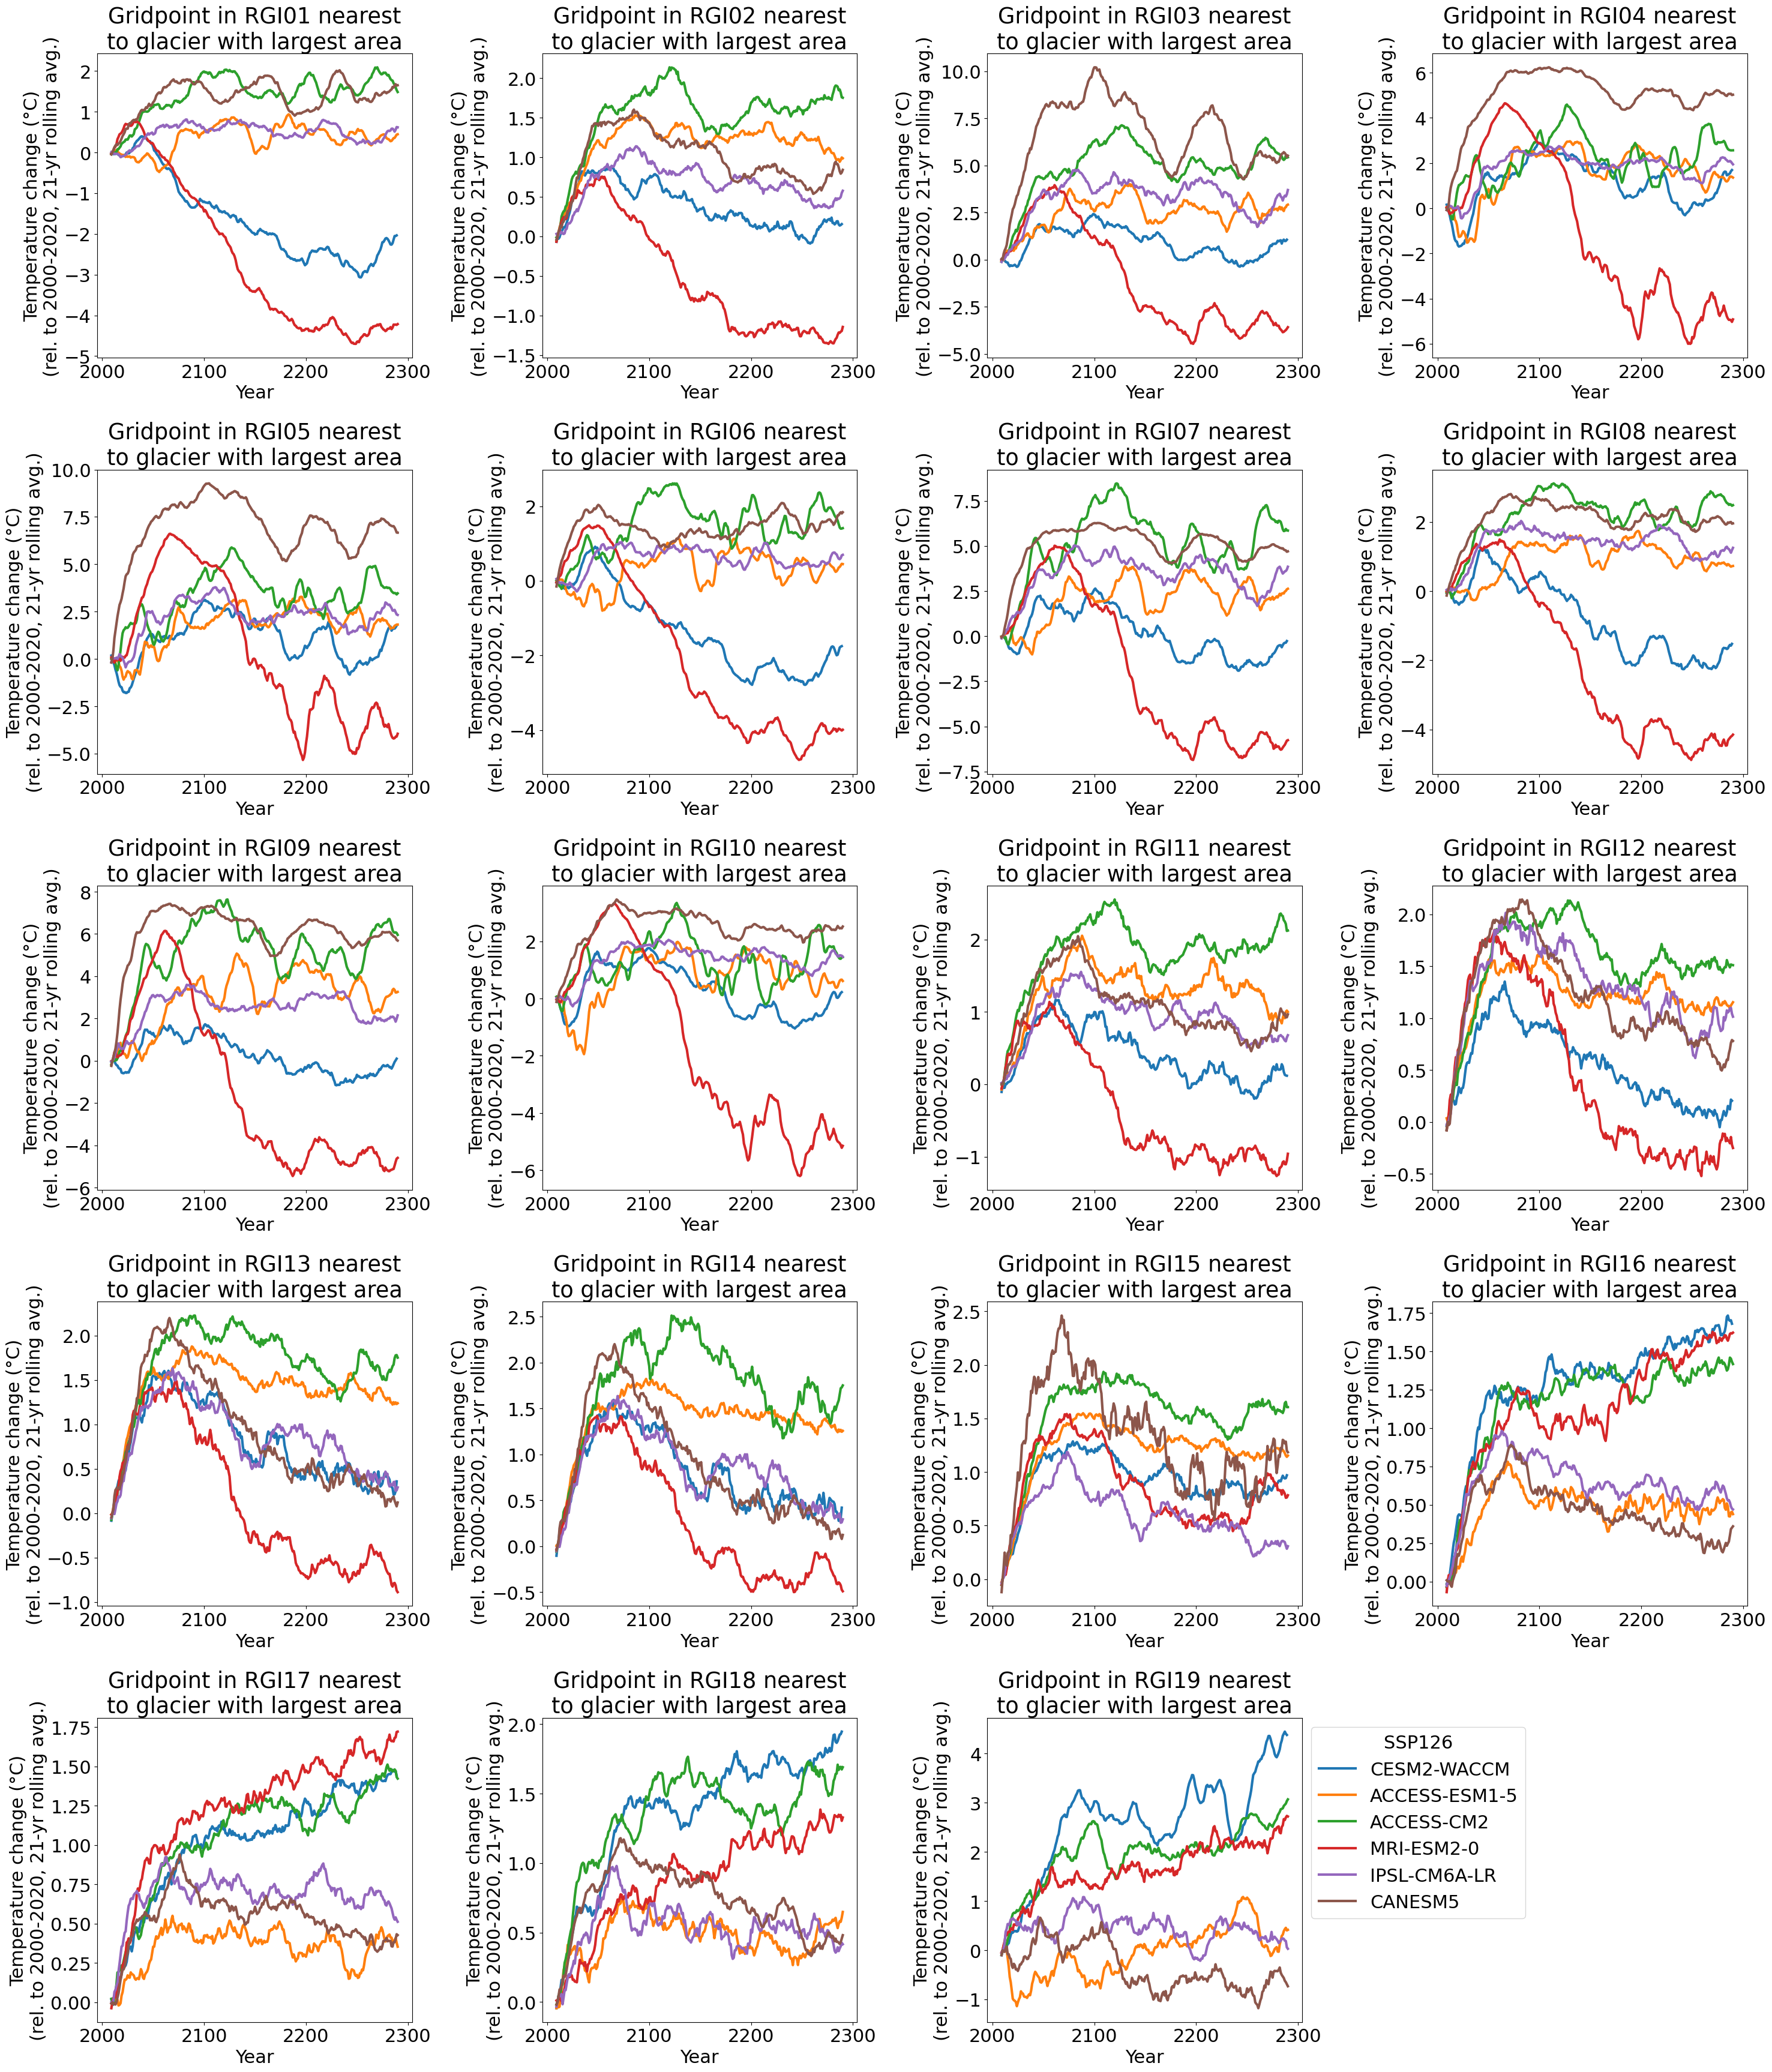

In [68]:
colors_gcm_d = {}
for jj,g in enumerate(['CESM2-WACCM', 'ACCESS-ESM1-5', 'ACCESS-CM2', 'MRI-ESM2-0',  'IPSL-CM6A-LR','CANESM5']):
    colors_gcm_d[g] = f'C{jj}'
plt.rc('font', size=22)
plt.figure(figsize=(30,35))
j = 1
for region in ['RGI01','RGI02', 'RGI03',
               'RGI04','RGI05', 'RGI06',
               'RGI07','RGI08', 'RGI09',
               'RGI10','RGI11', 'RGI12',
               'RGI13','RGI14', 'RGI15',
              'RGI16','RGI17', 'RGI18','RGI19']:
    plt.subplot(5,4,j)
    rgi = region[3:]
    CenLon, CenLat = odf.loc[odf.O1Region == f'{rgi}'].sort_values(by='Area').iloc[0][['CenLon','CenLat']].values

    for gcm in colors_gcm_d.keys():
        #if gcms_cmip6_2300_over.loc[f].folder == 'IPSL-CM6A-LR':
        #gcm = gcms_cmip6_2300_over.loc[f].folder
        dtas_annual = dtas_annual_d_ssp126[gcm]
        sel_rgi = dtas_annual.sel(lat = CenLat, lon = CenLon, method='nearest').sel(year=slice('1999', '2300')).rolling(year=21, center=True).mean()
        plt.plot(sel_rgi.year, sel_rgi.values-sel_rgi.sel(year=2010).values, label = gcm, color = colors_gcm_d[gcm.upper()], lw=3)
        #plt.title(f.folder)
    j +=1
    plt.title(f'Gridpoint in RGI{rgi} nearest\nto glacier with largest area')
    plt.ylabel('Temperature change (°C)\n(rel. to 2000-2020, 21-yr rolling avg.)')
    plt.xlabel('Year')
plt.tight_layout()
plt.legend(title='SSP126', bbox_to_anchor = (1,1), loc = 'upper left')


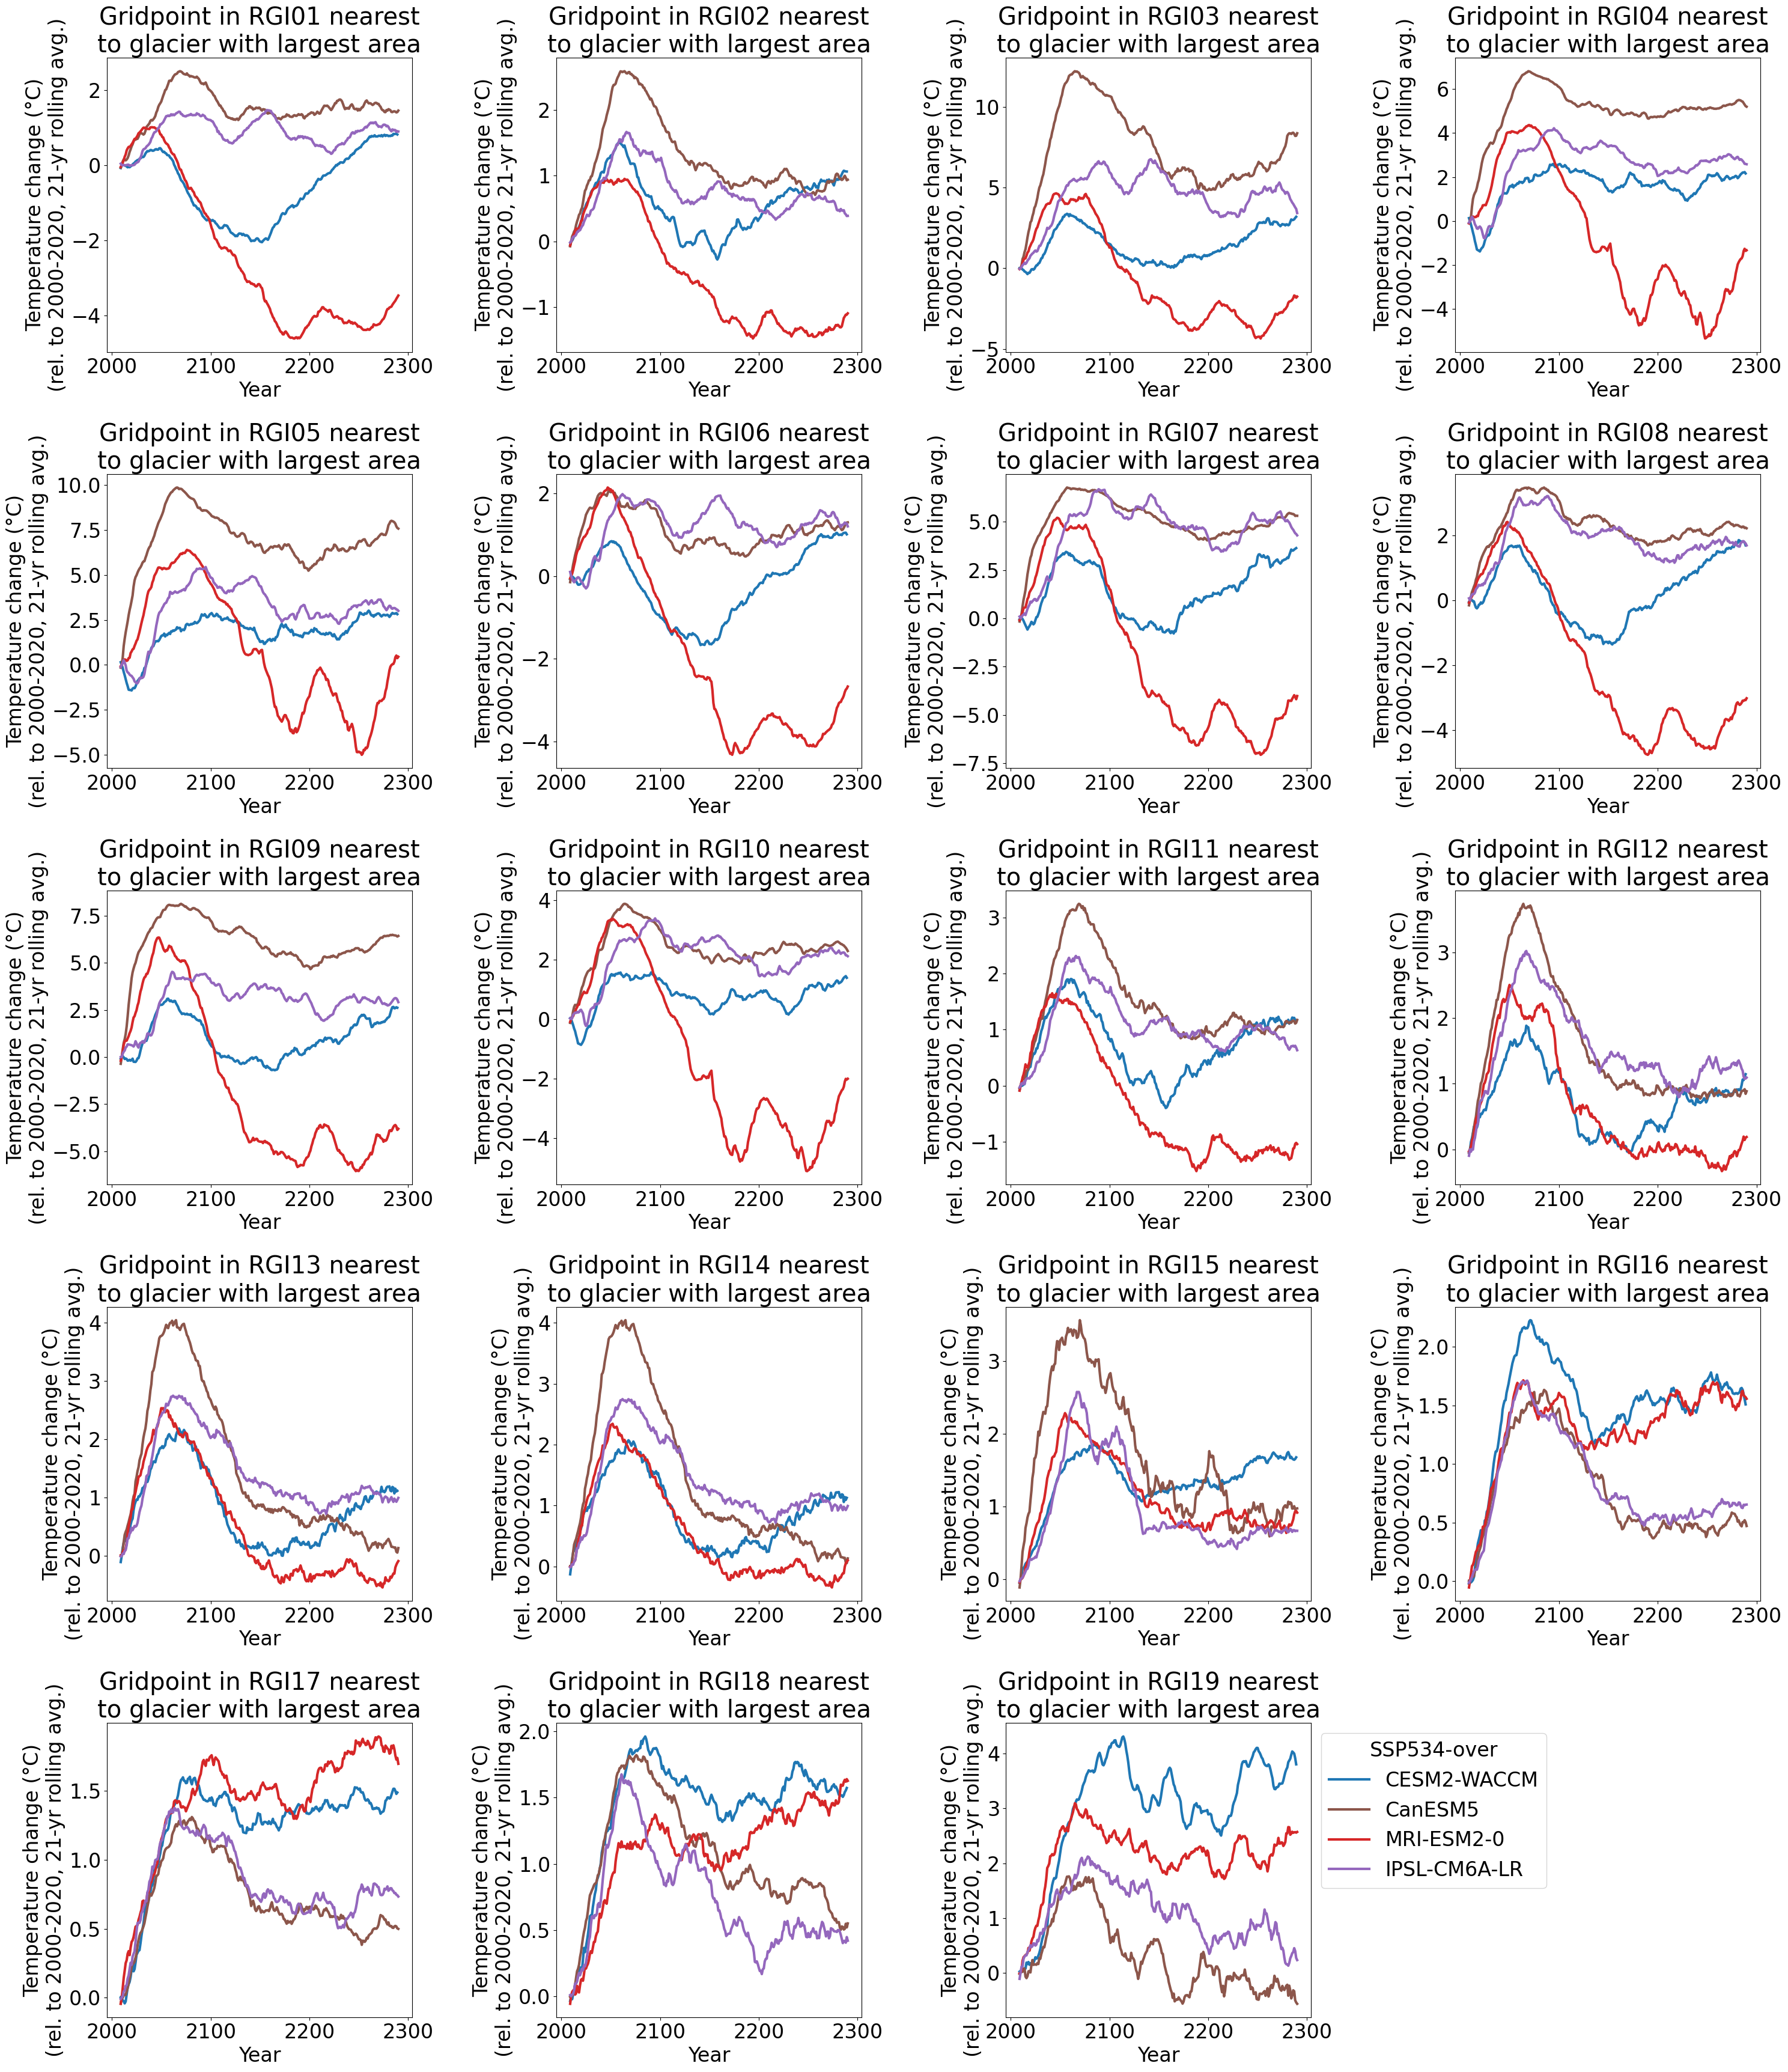

In [66]:
gcm_ssp_534_over = ['CESM2-WACCM', 'CanESM5','MRI-ESM2-0','IPSL-CM6A-LR']

plt.rc('font', size=24)
plt.figure(figsize=(30,35))
j = 1
for region in ['RGI01','RGI02', 'RGI03',
               'RGI04','RGI05', 'RGI06',
               'RGI07','RGI08', 'RGI09',
               'RGI10','RGI11', 'RGI12',
               'RGI13','RGI14', 'RGI15',
              'RGI16','RGI17', 'RGI18','RGI19']:
    plt.subplot(5,4,j)
    rgi = region[3:]
    CenLon, CenLat = odf.loc[odf.O1Region == f'{rgi}'].sort_values(by='Area').iloc[0][['CenLon','CenLat']].values

    for gcm in gcm_ssp_534_over:
        #if gcms_cmip6_2300_over.loc[f].folder == 'IPSL-CM6A-LR':
        #gcm = gcms_cmip6_2300_over.loc[f].folder
        dtas_annual = dtas_annual_d_ssp534_over[gcm.upper()]
        sel_rgi = dtas_annual.sel(lat = CenLat, lon = CenLon, method='nearest').sel(year=slice('1999', '2300')).rolling(year=21, center=True).mean()
        plt.plot(sel_rgi.year, sel_rgi.values-sel_rgi.sel(year=2010).values, label = gcm,color = colors_gcm_d[gcm.upper()], lw=3)
        #plt.title(f.folder)
    j +=1
    plt.title(f'Gridpoint in RGI{rgi} nearest\nto glacier with largest area')
    plt.ylabel('Temperature change (°C rel. to 2000-2020, 21-yr rolling avg.)')
    plt.ylabel('Temperature change (°C)\n(rel. to 2000-2020, 21-yr rolling avg.)')

    plt.xlabel('Year')
plt.tight_layout()
plt.legend(title='SSP534-over', bbox_to_anchor = (1,1), loc = 'upper left')


In [164]:
### trial code which does not work at the moment:
## get a mask for every RGI region 
ds_ref = xr.open_dataset(gcms_cmip6_2300_over.iloc[0]['path'], use_cftime=True)
#ds_ref = ds_ref.isel(lat=slice(1,-1))
ds_ref['test_values']  = (ds_ref.tas/ds_ref.tas).mean(dim='time')
max_lat = np.unique((ds_ref.lat.values[1:]-ds_ref.lat.values[:-1])/2)[0]
max_lon = np.unique(ds_ref.lon.values[1:] - ds_ref.lon.values[:-1])[0]/2
print(max_lat, max_lon)
ds_ref.coords['lon'] = np.where(ds_ref.lon.values < 0,
                                      ds_ref.lon.values + 360,
                                     ds_ref.lon.values)
ds_ref = ds_ref.sortby(ds_ref.lon)
ds_ref.lon.attrs['units'] = 'degrees_onlypositive'

# get the dataset where coordinates of glaciers are stored
frgi = utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5')
#frgi = '/home/users/lschuster/glacierMIP/rgi62_stats.h5'
odf = pd.read_hdf(frgi, index_col=0)

nx, ny = ds_ref.dims['lon'], ds_ref.dims['lat']
# just make them into 0-> 360 scheme
cenlon_for_bins = np.where(odf['CenLon'] < 0,
                           odf['CenLon']+360, odf['CenLon'])
#cenlon_for_bins = odf['CenLon']

# Nearest neighbor lookup
lon_bins = np.linspace(ds_ref.lon.data[0] - max_lon, ds_ref.lon.data[-1] + max_lon +1, nx) ##attential experimental, removed nx+1
lon_bins = ds_ref.lon_bnds.values.flatten()[::2]
# !!! attention W5E5 sorted from 90 to -90 !!!!
lat_bins = np.linspace(ds_ref.lat.data[0] - max_lat, ds_ref.lat.data[-1] + max_lat, ny+1)
# before it was wrongly 
# lon_bins = np.linspace(0, 360, nx), lat_bins = np.linspace(90, -90, ny)
# which created a non-aligned bins, in addition there was one bin missing, creating a slightly 
# larger resolution which after adding up a lot got problematic... 
# at the end it resulted in 19 glaciers where the nearest grid point was not found

odf['lon_id'] = np.digitize(cenlon_for_bins, lon_bins)-1
odf['lat_id'] = np.digitize(odf['CenLat'], lat_bins)-1
# this does not work, can that be removed???
odf['lon_val'] = ds_ref.lon.data[odf.lon_id]
odf['lat_val'] = ds_ref.lat.data[odf.lat_id]
# Use unique grid points as index and compute the area per location
odf['unique_id'] = ['{:03d}_{:03d}'.format(lon, lat) for (lon, lat) in zip(odf['lon_id'], odf['lat_id'])]
mdf = odf.drop_duplicates(subset='unique_id').set_index('unique_id')
mdf['Area'] = odf.groupby('unique_id').sum()['Area']
print('Total number of glaciers: {} and number of GCM gridpoints with glaciers in them: {}'.format(len(odf), len(mdf)))

# this is the mask that we need to remove all non-glacierized gridpoints
mask = np.full((ny, nx), np.NaN)
mask[mdf['lat_id'], mdf['lon_id']] = mdf['Area'] # 1
ds_ref['glacier_mask'] = (('lat', 'lon'), np.isfinite(mask))

# check the distance to the gridpoints-> it should never be larger than 
diff_lon = ds_ref.lon.data[odf.lon_id] - odf.CenLon
# if the distance is 360 -> it is the same as 0,
diff_lon = np.where(np.abs(diff_lon - 360) < 170, diff_lon-360, diff_lon)
odf['ll_dist_to_point'] = ((diff_lon)**2 + (ds_ref.lat.data[odf.lat_id] - odf.CenLat)**2)**0.5
assert odf['ll_dist_to_point'].max() < (max_lon**2 + max_lat**2)**0.5
# just select the glacier_mask variable:
ds_ref = ds_ref.drop_vars(['time_bnds','tas']).drop_dims('time')

ds_ref['glacier_area'] = (('lat', 'lon'), mask)
ds_ref['weight_glacier'] = (('lat', 'lon'), mask / np.nansum(mask))

reg = np.full((ny, nx), np.NaN)
reg[mdf['lat_id'], mdf['lon_id']] = mdf['O1Region'].astype(int)
ds_ref['rgi_region'] = (('lat', 'lon'), reg)

# Normal Weight
weight = np.cos(np.deg2rad(ds_ref.lat.astype(np.float64))).clip(0)
weight =  ds_ref.test_values * 0. + weight
ds_ref['weight'] = (('lat', 'lon'), weight.values / weight.sum().values)

# weighted average over latitudes
weight_regions = {}
weight_regions['global'] = ds_ref.weight  ##.sum(dim='lon')

# this is glacier area weighted
weight_regions['global_glacier']  = ds_ref.weight_glacier  ##.sum(dim='lon')
for rgi_reg in range(1, 20):
    weight_reg = ds_ref.weight_glacier.where(ds_ref.rgi_region == rgi_reg)
    weight_reg = weight_reg / weight_reg.sum()
    weight_regions[f'RGI{rgi_reg:02g}_glacier'] = weight_reg  ##.sum(dim='lon')
regions = weight_regions.keys()

1.3836359254576394 1.40625
Total number of glaciers: 216502 and number of GCM gridpoints with glaciers in them: 591


AssertionError: 

In [ ]:
l_pd_clim_glob_basin = []
    for scenario in ['stab_T12','stab_T15','oversh_T20OS15','oversh_T25OS15',
                     'oversh_T30OS15','stab_T20','stab_T25','stab_T30']:
        
        for region in regions:
            weight_sel = weight_regions[region]
            np.testing.assert_allclose(weight_sel.sum(),1)
            _pd_clim_glob_basin = pd.DataFrame(index=np.arange(1979,2500,1))

            dg_tas = xr.open_dataset(f'{path}/{scenario}/scenario_tas_annual.nc').t_ref
            global_dtas = (dg_tas * weight_sel).sum(dim='lon').sum(dim='lat')
            dg_precip = xr.open_dataset(f'{path}/{scenario}/scenario_precip_annual.nc').precip
            global_dprecip = (dg_precip * weight_sel).sum(dim='lon').sum(dim='lat')
            _pd_clim_glob_basin.loc[global_dtas.year,'temp'] = global_dtas.values
            _pd_clim_glob_basin['temp_20yr_avg'] = _pd_clim_glob_basin['temp'].rolling(20, center=True).mean()
            _pd_clim_glob_basin.loc[global_dtas.year,'precip'] = global_dprecip.values
            _pd_clim_glob_basin['precip_20yr_avg'] = _pd_clim_glob_basin['precip'].rolling(20, center=True).mean()
            _pd_clim_glob_basin.loc[global_dtas.year,'region'] = region
            _pd_clim_glob_basin.loc[global_dtas.year,'scenario'] = scenario
            _pd_clim_glob_basin.loc[global_dtas.year,'year'] = global_dtas.year.values
            l_pd_clim_glob_basin.append(_pd_clim_glob_basin)
    pd_clim_glob_rgi_reg = pd.concat(l_pd_clim_glob_basin).reset_index()
    pd_clim_glob_rgi_reg['year'] = pd_clim_glob_rgi_reg.year.astype(int).values
    pd_clim_glob_rgi_reg = pd_clim_glob_rgi_reg.drop(columns='index')
    #pd_clim_glob_rgi_reg.to_csv('annual_glob_glacier_rgi_reg_temp_precip_timeseries_oversh_stab.csv')